### **Importing Related Notebooks** 

In [2]:
import import_ipynb
import Data_Understanding

data = Data_Understanding.data

### **Explanatory Data Analysis**

##### **Monthly Charges and Tenure Relationship**

As explained in Data Understanding section, missing data, data input errors, or inconsistent data do not need to be handled further. Especially for anomalous data, it will be checked whether it exists or not by visualizing using library **Matplotlib** and **Seaborn**. In addition, Explanatory Data Analysis is very critical before building a predictive model. This includes identifying patterns, trends, relationships, anomalies in data, as well as revealing insights that may not be visible directly. First of all, there will be an examination of the `tenure` feature.

Text(0.5, 0.98, 'Tenure Distribution on Customer Churn')

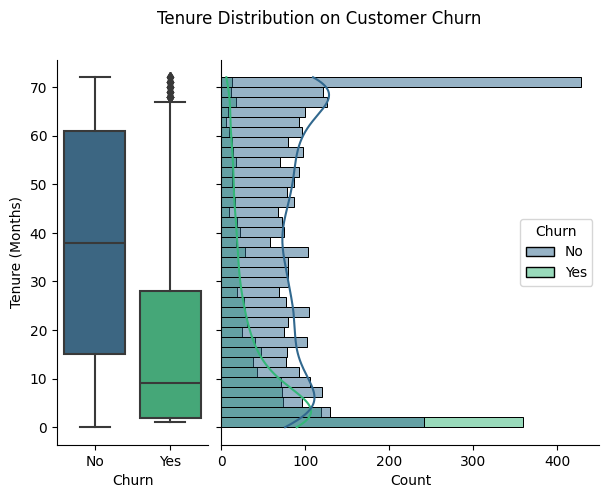

In [3]:
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(
    ncols=2,
    sharey=True,
    figsize=(7,5),
    gridspec_kw={
        'width_ratios':[2,5],
        'wspace':.05
    }
)

sns.boxplot(
    data=data,
    y='tenure',
    x='Churn',
    ax=ax[0],
    palette='viridis'
).set_ylabel('Tenure (Months)')

sns.histplot(
    data=data,
    y='tenure',
    hue='Churn',
    ax=ax[1],
    bins=35,
    palette='viridis',
    kde=True
)

sns.despine()
fig.suptitle('Tenure Distribution on Customer Churn')

It can be seen from the visualization above that most of the subscribers who churn are those whose subscription duration is relatively shorter than subscribers who are still subscribed. In addition, there is an anomaly in the form of upper outliers specifically for churn customers. Then, it is necessary to carry out further analysis to find out whether these outliers form different characteristics from non-outliers or in other words whether they are systemic or not. The trick is to find the mode difference from every other feature by using a contingency table.

Output contingency tables will be arranged separately in class `collective_outliers()`to facilitate the next inspection process.

In [4]:
import re
import pandas as pd

class collective_outliers:
    def __init__(self,churn:str,num_var:str,on:list=None,upper_outliers:bool=False,lower_outliers:bool=False):
        if on is None:
            desc = data[data['Churn']==churn][num_var].describe()
        else:
            self.on_var = (data[on[0]]==on[1])
            desc = data[
                (data['Churn']==churn) & 
                self.on_var
            ][num_var].describe()
        
        self.num_var, self.churn, self.on, q1, q3 = num_var, churn, on, desc['25%'], desc['75%']
        self.upper_value, self.lower_value = q3+(1.5*(q3-q1)), q1-(1.5*(q3-q1))
        self.upper_outliers, self.lower_outliers = upper_outliers, lower_outliers

        if upper_outliers & lower_outliers:
            self.slicing = (data[num_var]<self.lower_value) | (data[num_var]>self.upper_value)
        elif upper_outliers:
            self.slicing = (data[num_var]>self.upper_value)
        else:
            self.slicing = (data[num_var]<self.lower_value)
        
    def get_table(self):
        if self.on is None:
            stats = pd.concat(
                [
                    data[
                        (data['Churn']==self.churn) & 
                        i
                    ].describe(include='category').transpose() for i in [
                        self.slicing,
                        ~self.slicing
                    ]
                ],
                axis=1,
                keys=[
                    'Outliers',
                    'Non-Outliers'
                ]
            )
        else:
            stats = pd.concat(
                [
                    data[
                        (data['Churn']==self.churn) & 
                        self.on_var & 
                        i
                    ].describe(include='category').transpose() for i in [
                        self.slicing,
                        ~self.slicing
                    ]
                ],
                axis=1,
                keys=[
                     'Outliers',
                     'Non-Outliers'
                ]
            )
            
        stats[('Outliers','freq (%)')] = stats[[
            ('Outliers','count'),
            ('Outliers','freq')
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        self.diff = stats[stats[('Outliers','top')]!=stats[('Non-Outliers','top')]]        
        return self.diff
    
    def box_plot(self):
        if self.get_table()[('Outliers','top')][0] == 'No internet service':
            params = self.get_table()[self.get_table()[('Outliers','freq (%)')]!=100]
        else:
            params = self.get_table()
            
        fig, ax = plt.subplots(
            ncols=len(params)+1,
            figsize=((len(params)*5)+1.5,5),
            sharey=True,
            gridspec_kw={
                'wspace':.05,
                'width_ratios':[5]*len(params)+[1.5]
            }
        )

        for i,col in enumerate(params.index.values):
            base = data if self.on is None else data[data[self.on[0]]==self.on[1]]
            box = sns.boxplot(
                data=base,
                x=col,
                y=self.num_var,
                hue='Churn',
                ax=ax[i],
                palette='viridis'
            )

            var = re.sub(
                pattern=r'(?<=\w)([A-Z])',
                repl=r' \1',
                string=self.num_var
            ).title()

            box.set_ylabel(
                var if i == 0 else 
                ''
            )

            box.set_xlabel(
                re.sub(
                    pattern=r'(?<=\w)([A-Z])',
                    repl=r' \1',
                    string=col
                ).title()
            )

            line = self.lower_value if self.lower_outliers else self.upper_value
            box.axhline(
                y=line,
                color='red',
                linewidth=.5
            )
        
        sns.boxplot(
            data=base,
            x='Churn',
            y=self.num_var,
            palette='viridis'
        ).set_ylabel('')
        
        fig.suptitle(f'{var} Distribution on Features\nwith Systemic Modes')

First of all, the relationship to be analyzed is outliers and non-outliers from customers who churn based on the distribution of the `tenure` feature.

In [5]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    upper_outliers=True
)

diff.get_table()

Outliers                       Non-Outliers         \
                    count unique       top freq        count unique   
OnlineBackup           25      2       Yes   21         1291      3   
DeviceProtection       25      2       Yes   17         1291      3   
Contract               25      3  One year   10         1291      3   

                                       Outliers  
                             top  freq freq (%)  
OnlineBackup                  No   881     84.0  
DeviceProtection              No   843     68.0  
Contract          Month-to-month  1172     40.0

It can be seen that there is a mode difference between outliers and non-outliers in the `OnlineBackup`, `DeviceProtection` and `Contract` features with the percentage of mode respectively being 84 %, 68 % and 40 %. Then, visualization will be carried out to see the distribution.

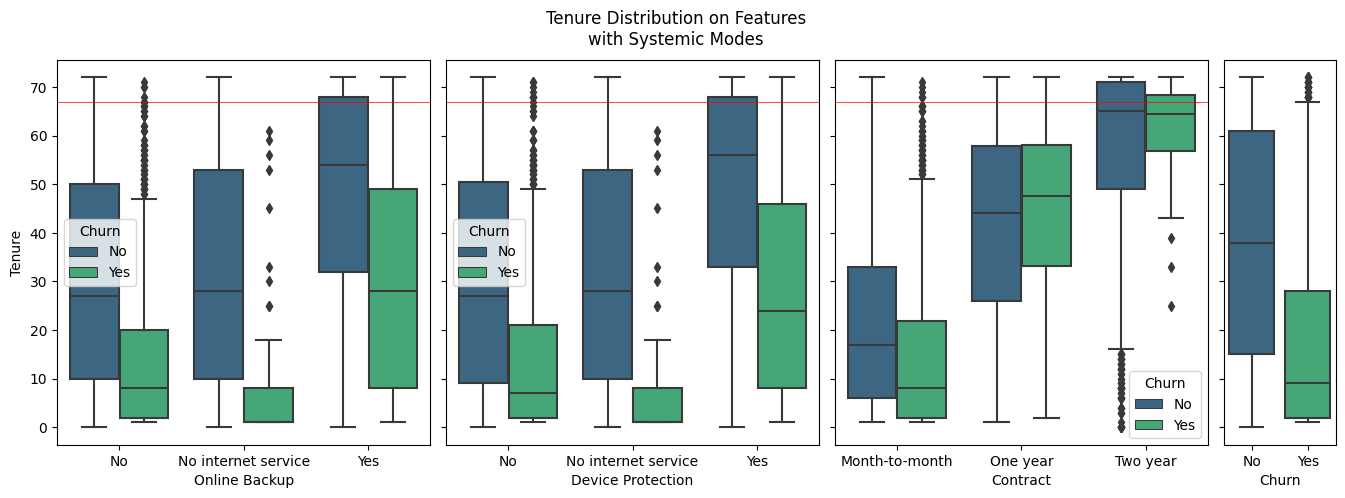

In [6]:
diff.box_plot()

It can be seen that there are extreme values ​​for the `No` class of the `OnlineBackup` and `DeviceProtection` features whose value exceeds the red horizontal line as the upper outliers limit of the `tenure` feature specifically for churn customers. The same goes for the `Month-to-month` class of the `Contract` feature. Therefore, deletion will only be carried out on those classes whose values ​​are in the upper outliers value range.

In the context of classification, this needs to be done because outliers can affect the performance of the machine learning model when making decisions, causing bias. By evaluating in this way, the class that has the most significant influence can be more easily detected by the model.

In [7]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (
        (data['OnlineBackup']=='No') | 
        (data['DeviceProtection']=='No') | 
        (data['Contract']=='Month-to-month')
    )
].index.values

data = data.drop(index=idx)

Next, a descriptive statistical analysis of the `tenure` feature will be carried out to see the distribution of customers who churn along with the mode values ​​that appear when associated with other features.

In [8]:
def get_info():
    if i == 0:
        display(thres)
    else:
        stats = data[
            (data['Churn']=='Yes') & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)

desc = data[data['Churn']=='Yes'][['tenure']].describe()
q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
slicing = data['tenure']<=q3
upper_outliers = data['tenure']>(q3+(1.5*(q3-q1)))

for i, thres in enumerate([desc.transpose(),slicing,-slicing,upper_outliers]):
    print(
        '\nDescriptive Statistics on Customer Churn',
        '{}.'.format(
            'based on Tenure' if i == 0 else 'whose Tenure is {} {} months'.format(
                'up to' if i == 1 else 'more than',
                int(q3)
            ) if i < 3 else 'whose Tenure is within outliers'
        )
    )
    
    get_info()


Descriptive Statistics on Customer Churn based on Tenure.


,count,mean,std,min,25%,50%,75%,max
tenure,1304.0,17.199387,18.716247,1.0,2.0,9.0,27.0,72.0



Descriptive Statistics on Customer Churn whose Tenure is up to 27 months.


,count,unique,top,freq,freq (%)
Dependents,984,2,No,830,84.35
OnlineSecurity,984,3,No,786,79.88
OnlineBackup,984,3,No,735,74.70
InternetService,984,3,Fiber optic,650,66.06
DeviceProtection,984,3,No,699,71.04
TechSupport,984,3,No,795,80.79
Contract,984,3,Month-to-month,963,97.87
PaperlessBilling,984,2,Yes,718,72.97
Churn,984,1,Yes,984,100.00



Descriptive Statistics on Customer Churn whose Tenure is more than 27 months.


,count,unique,top,freq,freq (%)
Dependents,320,2,No,251,78.44
OnlineSecurity,320,3,No,228,71.25
OnlineBackup,320,3,Yes,167,52.19
InternetService,320,3,Fiber optic,257,80.31
DeviceProtection,320,3,Yes,169,52.81
TechSupport,320,3,No,215,67.19
Contract,320,3,Month-to-month,209,65.31
PaperlessBilling,320,2,Yes,263,82.19
Churn,320,1,Yes,320,100.00



Descriptive Statistics on Customer Churn whose Tenure is within outliers.


,count,unique,top,freq,freq (%)
Dependents,36,2,No,24,66.67
OnlineSecurity,36,2,No,22,61.11
OnlineBackup,36,2,Yes,28,77.78
InternetService,36,2,Fiber optic,29,80.56
DeviceProtection,36,2,Yes,32,88.89
TechSupport,36,2,Yes,20,55.56
Contract,36,3,One year,16,44.44
PaperlessBilling,36,2,Yes,27,75.00
Churn,36,1,Yes,36,100.00


Based on the above calculations, insights that can be conveyed regarding the `tenure` feature are as follows:
1. Most of the customers who churn are those who subscribe for up to 27 months. The simple solution is to keep customers continuing to use the company's services beyond that duration because the chances of churn will be smaller.

1. The assumptions obtained are that customers who are used to and continue to use the service for more than 27 months are those who are satisfied with the quality of service obtained so that they fall into the category of loyal customers. Therefore, service quality must be maintained to maintain market segmentation that has been mastered.
1. Even though basically, there are other factors that cause regular customers to churn when they have subscribed for more than 27 months. It can be easily identified based on the mode value that emerges from every other categorical feature.
1. Similarly, in the range of outliers values, mode values ​​can be found for each other categorical feature. Thus, the company can conduct a thorough analysis for customers who churn, both in common cases which refer to situations that are general and easily predictable or edge cases which refer to situations that are unusual and difficult to predict.

The next step is to perform the same check on the `MonthlyCharges` feature. First of all, the data distribution will be visualized using boxplot and histogram.

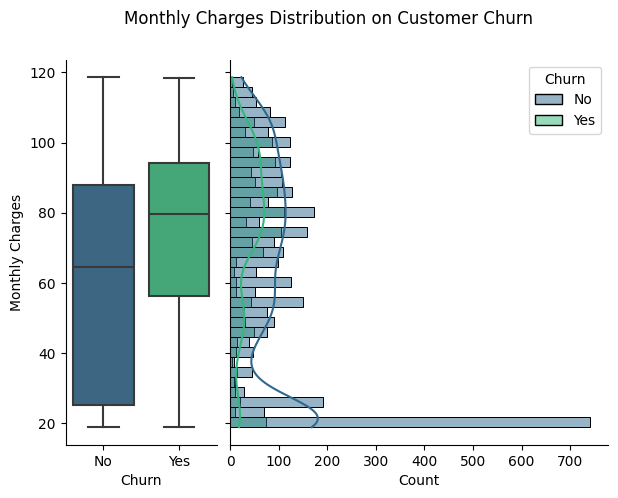

In [9]:
fig, ax = plt.subplots(
    ncols=2,
    sharey=True,
    figsize=(7,5),
    gridspec_kw={
        'width_ratios':[2,5],
        'wspace':.05
    }
)

sns.boxplot(
    data=data,
    y='MonthlyCharges',
    x='Churn',
    ax=ax[0],
    palette='viridis'
).set_ylabel('Monthly Charges')

sns.histplot(
    data=data,
    y='MonthlyCharges',
    hue='Churn',
    ax=ax[1],
    bins=35,
    palette='viridis',
    kde=True
)

fig.suptitle('Monthly Charges Distribution on Customer Churn')
sns.despine()

It can be seen that, based on the visualization above, churn customers generally pay more than customers who don't. In addition, no outliers were found, so special handling is not required regarding anomalous data in the `MonthlyCharges` feature. Next, a descriptive statistical analysis of the `MonthlyCharges` feature will be carried out to see the distribution of churn customers along with the mode values ​​that appear when associated with other features.

In [10]:
desc = data[data['Churn']=='Yes'][['MonthlyCharges']].describe()
q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

for i, thres in enumerate([desc.transpose(),slicing,-slicing]):
    print(
        '\nDescriptive Statistics on Customer Churn',
        '{}.'.format(
            'based on Monthly Charges' if i == 0 else 'whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if i == 1 else 'less than ',
                round(q1,2),
                'and' if i == 1 else 'or',
                '' if i == 1 else 'more than ',
                round(q3,2)
            )
        )
    )
    
    get_info()


Descriptive Statistics on Customer Churn based on Monthly Charges.


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,1304.0,74.344826,24.417257,18.85,56.25,79.650002,94.099998,118.349998



Descriptive Statistics on Customer Churn whose Monthly Charges is between 56.25 and 94.1.


,count,unique,top,freq,freq (%)
Dependents,655,2,No,549,83.82
OnlineSecurity,655,2,No,572,87.33
OnlineBackup,655,2,No,512,78.17
InternetService,655,2,Fiber optic,583,89.01
DeviceProtection,655,2,No,522,79.69
TechSupport,655,2,No,568,86.72
Contract,655,3,Month-to-month,617,94.20
PaperlessBilling,655,2,Yes,511,78.02
Churn,655,1,Yes,655,100.00



Descriptive Statistics on Customer Churn whose Monthly Charges is less than 56.25 or more than 94.1.


,count,unique,top,freq,freq (%)
Dependents,649,2,No,532,81.97
OnlineSecurity,649,3,No,442,68.10
OnlineBackup,649,3,No,369,56.86
InternetService,649,3,Fiber optic,324,49.92
DeviceProtection,649,3,No,321,49.46
TechSupport,649,3,No,442,68.10
Contract,649,3,Month-to-month,555,85.52
PaperlessBilling,649,2,Yes,470,72.42
Churn,649,1,Yes,649,100.00


Based on the above calculations, insights that can be conveyed regarding the `MonthlyCharges` feature are as follows:

1. The distribution of customers who churn, when viewed from their monthly bills, is divided into two parts of the value range, namely between 56 and 94 and outside of that value range. Therefore, it can be assumed that most customers who churn are those whose monthly bills are between 50 and 100.

1. Therefore, the assumption that can be conveyed is that some customers churn are dissatisfied with the quality of service in that price range or there are products with equivalent quality from competitors that cost less.
1. The simple solution is to evaluate the rates charged in that price range to determine whether or not the quality of service provided is worth the price.

Next, we will analyze the correlation between `MonthlyCharges` and `tenure`. First of all, a normality test will be performed using the Kolmogorov-Smirnov test. Although visually, the distribution of `MonthlyCharges` and `tenure` features is not normally distributed or symmetrically following a Gaussian distribution. However, it is important to carry out a normality test as an evaluation material.

In [11]:
from scipy.stats import kstest
import numpy as np

for i, col in enumerate(['MonthlyCharges','tenure']):
    stats, pvalue = kstest(
        rvs=data[col].values.reshape(-1),
        cdf=np.random.normal(
            loc=data[col].values.mean(),
            scale=data[col].values.std(),
            size=len(data[col].values.reshape(-1))
        )
    )

    print(
        '{} feature {} normal distribution.'.format(
            'Monthly Charges' if i == 0 else 'Tenure',
            'follows' if pvalue > 0.05 else "doesn't follow"
        )
    )

Monthly Charges feature doesn't follow normal distribution.
Tenure feature doesn't follow normal distribution.


Based on the normality test above, it can be proven that the two features do not follow the normality assumptions that apply. Therefore, the correlation test will use the Spearman method.

In [12]:
data[['tenure','MonthlyCharges']].corr(method='spearman')

,tenure,MonthlyCharges
tenure,1.000000,0.264195
MonthlyCharges,0.264195,1.000000


It was found that the correlation value between `MonthlyCharges` and `tenure` features is positive but not of great value. That means that the resulting relationship between the two creates a trend that is not so significant. It should be noted that correlation cannot show a causal relationship and only measures how close the relationship is between the two. Then a visualization will be carried out to see the correlation based on customers who churn or not.

Text(37.722222222222214, 0.5, 'Monthly Charges')

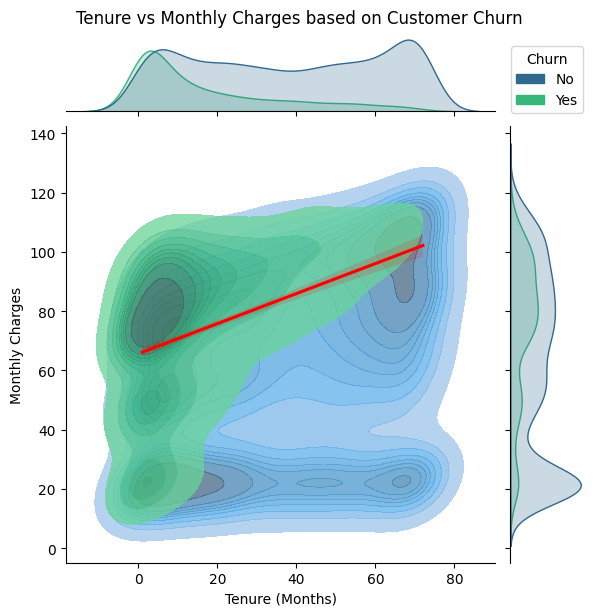

In [13]:
joint = sns.jointplot(
    x=data['tenure'],
    y=data['MonthlyCharges'],
    hue=data['Churn'],
    kind='kde',
    fill=True,
    alpha=.75,
    palette='viridis'
)

joint.fig.suptitle(
    t='Tenure vs Monthly Charges based on Customer Churn', 
    y=1.02
)

joint.ax_joint.get_legend().set_bbox_to_anchor(bbox=(1.22,1.2))

sns.regplot(
    data=data[data['Churn']=='Yes'],
    x='tenure',
    y='MonthlyCharges',
    scatter=False,
    color='red'
)

plt.xlabel('Tenure (Months)')
plt.ylabel('Monthly Charges')

Based on the visualization results, it appears that there is a linear relationship between the `tenure` and `MonthlyCharges` features for churn customers although the resulting correlation is not so significant. That means that customers who churn are those whose subscription duration is longer, the fees charged will be more expensive. The assumptions that can be concluded can be described as follows:

1. It's normal that the longer the subscription, the more expensive the rate paid will be due to the end of the promo period, so this applies both to churn customers and those who don't.

1. The longer the subscription, the increase in the rate charged is not proportional to the increase in the perceived quality of service.
1. Customers whose promotion period has expired will consider this as a loss. In economics, this phenomenon is known as behavioural economics which explains that humans tend to avoid more losses (loss aversion) than seek profits (gain seeking).

The solutions offered include:

1. Communicate clearly to customers regarding the promo period which will expire when approaching the specified deadline so that it is not considered a unilateral decision when the tariff charged will increase to the normal price.

1. Providing membership programs or advanced promotions to maintain and improve good relations between the company and customers.
1. Increasing the value of services can increase customer retention, including in the form of improving service quality, new features or advantages, and loyalty programs as a form of incentive so that customers remain loyal in using the company's services.

##### **Internet Service**

The `InternetService` feature is a condition that describes whether the customer is using the service or not. In the early stages, it will be examined what classes are contained considering that the feature is of a categorical type.

In [14]:
data['InternetService'].unique()

['DSL', 'Fiber optic', 'No']
Categories (3, object): ['DSL', 'Fiber optic', 'No']

It can be seen that there are 3 classes used. Basically, the `iber optic` and `DSL` classes are the types of technology of service used by subscribers. Conversely, customers who do not use the service will be given a `No` condition as an indicator that they are not using any type of service in that feature.

Then, it will be seen the value distribution of each class between customers who churn or not based on the `tenure` and `MonthlyCharges` features.

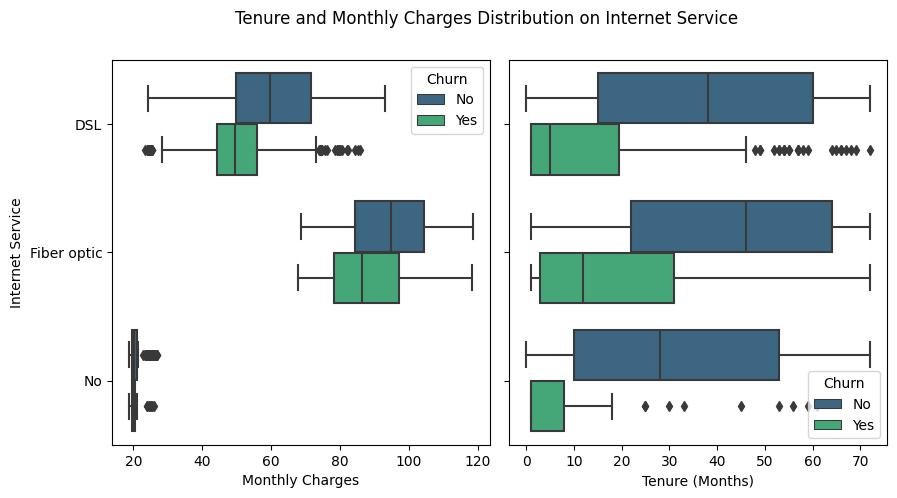

In [15]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Internet Service')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['InternetService'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    box.set_ylabel('Internet Service' if i == 0 else '')

It can be seen that `Fiber optic` service has a higher price range than `DSL`. This is because `Fiber optic` uses more sophisticated technology and more expensive installation costs. On the other hand, there are customers who do not use the `InternetService` service but are still charged a monthly fee as a basic fee so that the current contract remains active. There are several assumptions that can be described regarding the characteristics of these customers, including:

1. The customer may have decided to temporarily stop using the internet service for certain reasons, such as being too expensive.

1. The subscriber may have just registered for a subscription but has not yet activated the `InternetService` service.
1. Customers may not have access to the `InternetService` service at their place of residence so they decide not to use any service even if they have to pay a monthly fee because the contract duration has not ended. It can be seen that most of those who churn are those whose contract duration is under 7 months. This means that once the contract ends, customers who experience this situation will not renew their subscription contract, especially those whose contract duration is on a `Month-to-month` basis.
1. A customer may use the services of a competitor but still retain the existing contract for some reason. This can be termed as multi-channel consumer which refers to customers who utilize many service channels but are not loyal in using one particular product on a regular basis. In the industry, customers with these characteristics are often the target of marketing and customer retention strategies due to their potential to increase sales and customer loyalty.

In this case, the company must be able to identify the factors that cause customers not to use the `InternetService` service, such as bills that are not proportional to the quality of service, and provide the right solution to meet their needs. This will help retain customers as active customers and increase customer satisfaction.

Regarding customers who use the `InternetService` service, based on the `DSL` class it appears that most of the churn are those whose monthly bills are in the range of 40 to 60 while for the `Fiber optic` class most of those churn is between 80 and 100.

On the other hand, it appears that there are anomalous data in the form of outliers for the `DSL` and `No` classes. Therefore, it is necessary to examine the data in the same way as before with the aim of seeing the differences in outliers and non-outliers characteristics in each other feature. First of all, the relationships to be analyzed are outliers and non-outliers of customers who churn on the `DSL` class of the `InternetService` feature based on the distribution of the `MonthlyCharges` feature.

In [16]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['InternetService','DSL'],
    upper_outliers=True,
    lower_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

It can be seen that there is no difference in the mode value between outliers and non-outliers for each feature, so there is no need to process anomaly data. Next, we will analyze the relationship between outliers and non-outliers, both from churn customers and those who do not, in the `No` class of the `InterService` feature based on the distribution of the `MonthlyCharges` feature.

In [17]:
for i, val in enumerate(['No','Yes']):
    print(
        '\nFeatures with Systemic Modes on class No of Internet Service',
        'whose customers are{} churn.'.format(' not' if i == 0 else '')
    )

    diff = collective_outliers(
        churn=val,
        num_var='MonthlyCharges',
        on=['InternetService','No'],
        upper_outliers=True
    )
    
    display(diff.get_table())


Features with Systemic Modes on class No of Internet Service whose customers are not churn.


Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []


Features with Systemic Modes on class No of Internet Service whose customers are churn.


Outliers                  Non-Outliers                  \
                    count unique  top freq        count unique top freq   
PaperlessBilling        8      2  Yes    5           74      2  No   49   

                 Outliers  
                 freq (%)  
PaperlessBilling     62.5

It can be seen that there are different characteristics between outliers and non-outliers in the special `PaperlessBilling` feature for churn customers. On the other hand, there are no systemic differences in subscribers who are still subscribing. Therefore, outliers handling will only be carried out on classes that produce different characteristics between outliers and non-outliers. Before that, a visualization will be carried out to see the distribution.

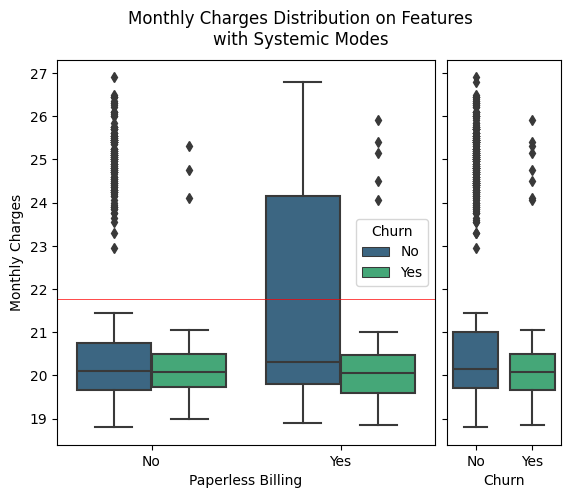

In [18]:
diff.box_plot()

Based on the visualization results, it appears that there are outliers for the `No` and `Yes` classes of the `PaperlessBilling` feature, for both churn and non-churn customers, which exceed the red upper outliers limit. Even so, deletion will only be carried out for outliers who have different characteristics from non-outliers as explained in the previous section of the contingency table, namely the `No` and `Yes` classes specifically for customers who churn.

In [19]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']>diff.upper_value) & 
    (data['InternetService']=='No') &
    (
        (data['PaperlessBilling']=='No') | 
        (data['PaperlessBilling']=='Yes')
    )
].index.values

data = data.drop(index=idx)

Next, we will analyze the outliers and non-outliers relationships of customers who churn on the `DSL` class of the `InternetService` feature based on the distribution of the `tenure` feature.

In [20]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['InternetService','DSL'],
    upper_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                 Outliers
                count unique  top freq        count unique top freq freq (%)
OnlineBackup       24      2  Yes   14          291      2  No  228    58.33

It was found that there is a mode difference in the `OnlineBackup` feature with a frequency value of 58%. Then, visualization will be carried out to see the distribution.

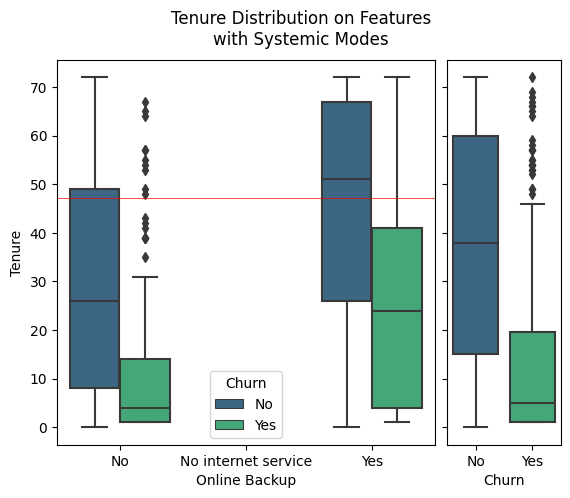

In [21]:
diff.box_plot()

It appears that there are extreme values ​​for the `No` class of the `OnlineBackup` feature that goes beyond the upper outliers line specifically for churn customers. Class `No internet service` is not included in the visualization because basically when a customer uses `DSL` service, the calculation of additional service features will only be divided into `Yes` or `No`. Therefore, deletion will only be carried out in class `No` whose outliers value is in the upper outliers range.

In [22]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['InternetService']=='DSL') &
    (data['OnlineBackup']=='No')
].index.values

data = data.drop(index=idx)

Next, we will analyze the outliers and non-outliers relationships of customers who churn on the `No` class of the `InternetService` feature based on the distribution of the `tenure` feature.

In [23]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['InternetService','No'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

It can be seen that there is no difference in the mode value between outliers and non-outliers for each feature, so there is no need to process anomaly data. Next, we will analyze the proportion of customers who churn or not based on each class of the `InternetService` feature.

Text(0.5, 0.98, 'Internet Service Proportion')

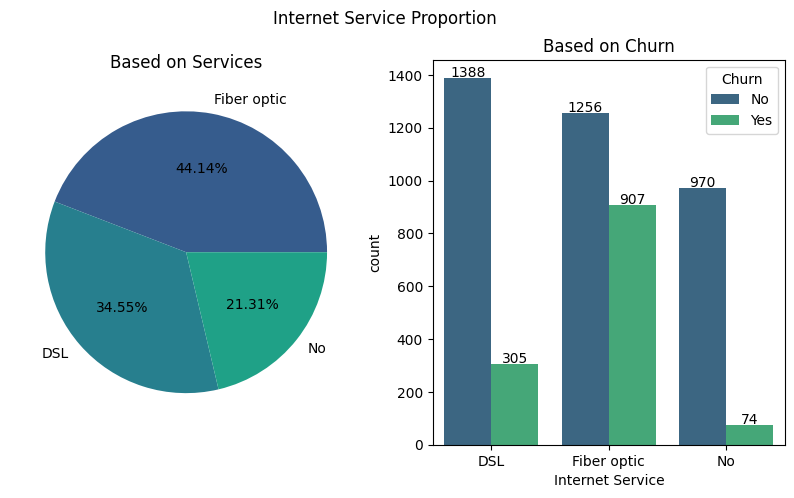

In [24]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5)
)

sns.countplot(
    x=data['InternetService'],
    hue=data['Churn'],
    palette='viridis',
    ax=ax[1]
).set_title('Based on Churn')

ax[1].set_xlabel('Internet Service')
axes = plt.gca()

for p in axes.patches:
    axes.annotate(
        text=f'{p.get_height():.0f}',
        xy=(
            (p.get_x()+(p.get_width()/2)),
            (p.get_height()+5)
        ),
        ha='center'
    )

ax[0].pie(
    x=data['InternetService'].value_counts(),
    labels=data['InternetService'].value_counts().index,
    autopct='%.2f%%',
    colors=sns.color_palette('viridis')[1:4]
)

ax[0].set_title('Based on Services')
fig.suptitle('Internet Service Proportion')

Based on the number of users, `Fiber optic` service is ranked first, followed by `DSL`. In addition, the rest do not use both services. Users of `DSL` services have a much lower ratio of subscribers churn than `Fiber optic` services. Therefore, it is necessary to pay special attention to users of `Fiber optic` services to find out what factors cause a quite large churn subscriber ratio.

In accordance with previous insights, the rates charged for `Fiber optic` services tend to be more expensive than `DSL` because they use more sophisticated technology and are also more expensive in terms of cost. Even so, an evaluation is still needed whether the quality provided is commensurate with the rates charged. In addition, there are other alternatives such as `DSL` which may be sufficient to meet the needs and according to customer preferences. The solutions offered for this problem include:

1. Offer customers who churn to use other alternatives that suit their needs so customers don't have to switch services to competitors.

1. Provide a clear and thorough understanding objectively regarding the advantages and disadvantages of each service. This is done so that customers are not disappointed with service recommendations that are not on target and tend to push selling.
1. Customers who experience good service quality and service will ultimately be comfortable and will not switch to competitors when they want to make changes to the services used, such as switching from `DSL` to `Fiber optic`, with the guarantee that the quality of service `Fiber optic` is no worse.
1. Re-evaluate the rates charged for `Fiber optic` services.

Next, a descriptive statistical analysis of the `InternetService` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [25]:
data[data['Churn']=='Yes'].groupby('InternetService').describe().transpose()

InternetService              DSL  Fiber optic         No
tenure         count  305.000000   907.000000  74.000000
               mean    12.491803    19.160970   6.662162
               std     15.628945    19.185584  12.707755
               min      1.000000     1.000000   1.000000
               25%      1.000000     3.000000   1.000000
               50%      5.000000    12.000000   1.000000
               75%     17.000000    31.000000   6.750000
               max     72.000000    72.000000  61.000000
MonthlyCharges count  305.000000   907.000000  74.000000
               mean    49.236721    87.783249  19.975676
               std     13.179351    11.814795   0.528129
               min     23.450001    67.750000  18.850000
               25%     43.950001    78.375000  19.612500
               50%     49.549999    86.449997  19.975000
               75%     55.349998    97.224998  20.250000
               max     85.949997   118.349998  21.049999

Based on this analysis, the insight obtained can be described as follows:

1. Based on the `DSL` service, most of the subscribers churn are those whose subscription duration is up to 17 months and the bills charged range from 40 to 60.

1. Based on the `Fiber optic` service, most customers who churn are those whose subscription duration is up to 31 months and the bills charged range from 75 to 100.
1. Based on those who do not use the `InternetService` service, most customers who churn are those whose subscription duration is up to 7 months and the bills charged range from 19 to 21.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of subscribers who churn were those who subscribed for up to 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases one can use analysis results based on the type of service used in the `InternetService` feature.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `InternetService` feature when associated with the `tenure` and `MonthlyCharges` features. Furthermore, a descriptive statistical analysis of the `InternetService` feature will also be carried out to find out the mode value that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [26]:
for i in data['InternetService'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['InternetService']==i)
    ][['tenure']].describe()
    
    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}{}'.format(
                'subscribes ' if i != 'No' else "doesn't subscribe any services",
                i if i != 'No' else ''
            ),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )
        
        stats = data[
            (data['Churn']=='Yes') & 
            (data['InternetService']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(lambda x: round((x[1]/x[0])*100,2),axis=1)
        
        display(stats)


Descriptive Statistics on Customer Churn who subscribes DSL whose Tenure is up to 17 months.


,count,unique,top,freq,freq (%)
Dependents,229,2,No,185,80.79
OnlineSecurity,229,2,No,190,82.97
OnlineBackup,229,2,No,193,84.28
InternetService,229,1,DSL,229,100.00
DeviceProtection,229,2,No,191,83.41
TechSupport,229,2,No,183,79.91
Contract,229,2,Month-to-month,223,97.38
PaperlessBilling,229,2,Yes,137,59.83
Churn,229,1,Yes,229,100.00



Descriptive Statistics on Customer Churn who subscribes DSL whose Tenure is more than 17 months.


,count,unique,top,freq,freq (%)
Dependents,76,2,No,54,71.05
OnlineSecurity,76,2,No,42,55.26
OnlineBackup,76,2,Yes,41,53.95
InternetService,76,1,DSL,76,100.00
DeviceProtection,76,2,No,39,51.32
TechSupport,76,2,No,48,63.16
Contract,76,3,Month-to-month,50,65.79
PaperlessBilling,76,2,Yes,55,72.37
Churn,76,1,Yes,76,100.00



Descriptive Statistics on Customer Churn who subscribes Fiber optic whose Tenure is up to 31 months.


,count,unique,top,freq,freq (%)
Dependents,682,2,No,585,85.78
OnlineSecurity,682,2,No,608,89.15
OnlineBackup,682,2,No,538,78.89
InternetService,682,1,Fiber optic,682,100.00
DeviceProtection,682,2,No,512,75.07
TechSupport,682,2,No,616,90.32
Contract,682,2,Month-to-month,675,98.97
PaperlessBilling,682,2,Yes,562,82.40
Churn,682,1,Yes,682,100.00



Descriptive Statistics on Customer Churn who subscribes Fiber optic whose Tenure is more than 31 months.


,count,unique,top,freq,freq (%)
Dependents,225,2,No,185,82.22
OnlineSecurity,225,2,No,171,76.00
OnlineBackup,225,2,Yes,120,53.33
InternetService,225,1,Fiber optic,225,100.00
DeviceProtection,225,2,Yes,129,57.33
TechSupport,225,2,No,158,70.22
Contract,225,3,Month-to-month,149,66.22
PaperlessBilling,225,2,Yes,189,84.00
Churn,225,1,Yes,225,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any services whose Tenure is up to 6 months.


,count,unique,top,freq,freq (%)
Dependents,55,2,No,48,87.27
OnlineSecurity,55,1,No internet service,55,100.00
OnlineBackup,55,1,No internet service,55,100.00
InternetService,55,1,No,55,100.00
DeviceProtection,55,1,No internet service,55,100.00
TechSupport,55,1,No internet service,55,100.00
Contract,55,2,Month-to-month,54,98.18
PaperlessBilling,55,2,No,36,65.45
Churn,55,1,Yes,55,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any services whose Tenure is more than 6 months.


,count,unique,top,freq,freq (%)
Dependents,19,2,No,12,63.16
OnlineSecurity,19,1,No internet service,19,100.00
OnlineBackup,19,1,No internet service,19,100.00
InternetService,19,1,No,19,100.00
DeviceProtection,19,1,No internet service,19,100.00
TechSupport,19,1,No internet service,19,100.00
Contract,19,3,Month-to-month,14,73.68
PaperlessBilling,19,2,No,13,68.42
Churn,19,1,Yes,19,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which class of other features has the greatest chance of appearing and has the potential to cause customers to churn if it is linked to each class of the `InternetService` feature based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [27]:
for i in data['InternetService'].unique():
    desc = data[(data['Churn']=='Yes') & (data['InternetService']==i)][['MonthlyCharges']].describe()
    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}{}'.format(
                'subscribes ' if i != 'No' else "doesn't subscribe any services",
                i if i != 'No' else ''
            ),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )
        
        stats = data[
            (data['Churn']=='Yes') & 
            (data['InternetService']==i) & 
            (thres)
        ].describe(include='category').transpose()
        
        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        display(stats)


Descriptive Statistics on Customer Churn who subscribes DSL whose Monthly Charges is between 43.95 and 55.35.


,count,unique,top,freq,freq (%)
Dependents,154,2,No,125,81.17
OnlineSecurity,154,2,No,129,83.77
OnlineBackup,154,2,No,128,83.12
InternetService,154,1,DSL,154,100.00
DeviceProtection,154,2,No,125,81.17
TechSupport,154,2,No,132,85.71
Contract,154,3,Month-to-month,147,95.45
PaperlessBilling,154,2,Yes,99,64.29
Churn,154,1,Yes,154,100.00



Descriptive Statistics on Customer Churn who subscribes DSL whose Monthly Charges is less than 43.95 or more than 55.35.


,count,unique,top,freq,freq (%)
Dependents,151,2,No,114,75.50
OnlineSecurity,151,2,No,103,68.21
OnlineBackup,151,2,No,100,66.23
InternetService,151,1,DSL,151,100.00
DeviceProtection,151,2,No,105,69.54
TechSupport,151,2,No,99,65.56
Contract,151,3,Month-to-month,126,83.44
PaperlessBilling,151,2,Yes,93,61.59
Churn,151,1,Yes,151,100.00



Descriptive Statistics on Customer Churn who subscribes Fiber optic whose Monthly Charges is between 78.38 and 97.22.


,count,unique,top,freq,freq (%)
Dependents,453,2,No,382,84.33
OnlineSecurity,453,2,No,402,88.74
OnlineBackup,453,2,No,332,73.29
InternetService,453,1,Fiber optic,453,100.00
DeviceProtection,453,2,No,334,73.73
TechSupport,453,2,No,401,88.52
Contract,453,3,Month-to-month,434,95.81
PaperlessBilling,453,2,Yes,374,82.56
Churn,453,1,Yes,453,100.00



Descriptive Statistics on Customer Churn who subscribes Fiber optic whose Monthly Charges is less than 78.38 or more than 97.22.


,count,unique,top,freq,freq (%)
Dependents,454,2,No,388,85.46
OnlineSecurity,454,2,No,377,83.04
OnlineBackup,454,2,No,311,68.50
InternetService,454,1,Fiber optic,454,100.00
DeviceProtection,454,2,No,274,60.35
TechSupport,454,2,No,373,82.16
Contract,454,3,Month-to-month,390,85.90
PaperlessBilling,454,2,Yes,377,83.04
Churn,454,1,Yes,454,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any services whose Monthly Charges is between 19.61 and 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,2,Month-to-month,34,91.89
PaperlessBilling,37,2,No,26,70.27
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any services whose Monthly Charges is less than 19.61 or more than 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,3,Month-to-month,34,91.89
PaperlessBilling,37,2,No,23,62.16
Churn,37,1,Yes,37,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which class of other features has the greatest chance of appearing and has the potential to cause customers to churn if it is linked to each class of the `InternetService` feature based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, it will calculate the number of customer events that churn or not based on grouping the `InternetService` feature with every other categorical feature.

In [28]:
for i in data.drop(['InternetService','tenure','MonthlyCharges','Churn'],axis=1).columns:
    print(f'Cummulative Churn for Internet Service and {i}.')
    display(data[data['Churn']=='Yes'].groupby([
        'InternetService',
        i
    ])[['Churn']].count().rename(columns={'Churn':'Count'}))

Cummulative Churn for Internet Service and Dependents.


Count
InternetService Dependents       
DSL             No            239
                Yes            66
Fiber optic     No            770
                Yes           137
No              No             60
                Yes            14

Cummulative Churn for Internet Service and OnlineSecurity.


Count
InternetService OnlineSecurity            
DSL             No                     232
                No internet service      0
                Yes                     73
Fiber optic     No                     779
                No internet service      0
                Yes                    128
No              No                       0
                No internet service     74
                Yes                      0

Cummulative Churn for Internet Service and OnlineBackup.


Count
InternetService OnlineBackup              
DSL             No                     228
                No internet service      0
                Yes                     77
Fiber optic     No                     643
                No internet service      0
                Yes                    264
No              No                       0
                No internet service     74
                Yes                      0

Cummulative Churn for Internet Service and DeviceProtection.


Count
InternetService DeviceProtection          
DSL             No                     230
                No internet service      0
                Yes                     75
Fiber optic     No                     608
                No internet service      0
                Yes                    299
No              No                       0
                No internet service     74
                Yes                      0

Cummulative Churn for Internet Service and TechSupport.


Count
InternetService TechSupport               
DSL             No                     231
                No internet service      0
                Yes                     74
Fiber optic     No                     774
                No internet service      0
                Yes                    133
No              No                       0
                No internet service     74
                Yes                      0

Cummulative Churn for Internet Service and Contract.


Count
InternetService Contract             
DSL             Month-to-month    273
                One year           28
                Two year            4
Fiber optic     Month-to-month    824
                One year           65
                Two year           18
No              Month-to-month     68
                One year            5
                Two year            1

Cummulative Churn for Internet Service and PaperlessBilling.


Count
InternetService PaperlessBilling       
DSL             No                  113
                Yes                 192
Fiber optic     No                  156
                Yes                 751
No              No                   49
                Yes                  25

Based on these calculations, a pattern is seen for the number of subscribers churn based on the classification of the `InternetService` feature. This pattern can be observed because basically the `InternetService` feature is the main service while the other features are additional services, including `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` and `TechSupport`. The interpretation obtained can be described as follows:

1. Customers who do not use any type of service from the `InternetService` feature will automatically enter the `No internet service` class in additional service features. Therefore, the aggregation value obtained will be separate from other classes, namely `Yes` or `No`.

1. The classes used in the four features will be interpreted as follows:
    - The class `Yes` indicates that the subscriber is using the `InternetService` service and still activates the additional service.
    
    - The class `No` indicates that the subscriber uses the `InternetService` service but does not activate additional services.
    - Class `No internet service` indicates that the customer does not use any type of `InternetService` service so that it can be ensured that additional services are default inactive.
1. Most customers who churn are those who use one of the `InternetService` services but do not activate additional services. A more in-depth examination of this matter will be carried out in the following discussion.

##### **Additional Services**

As explained earlier, there are other services, namely `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` and `TechSupport`, which are provided by companies specifically for those who use one of the `InternetService` services. This can be considered as an additional or optional service which the customer can choose to activate or not.

**Online Security Features**

First of all, a boxplot visualization will be performed to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `OnlineSecurity` feature.

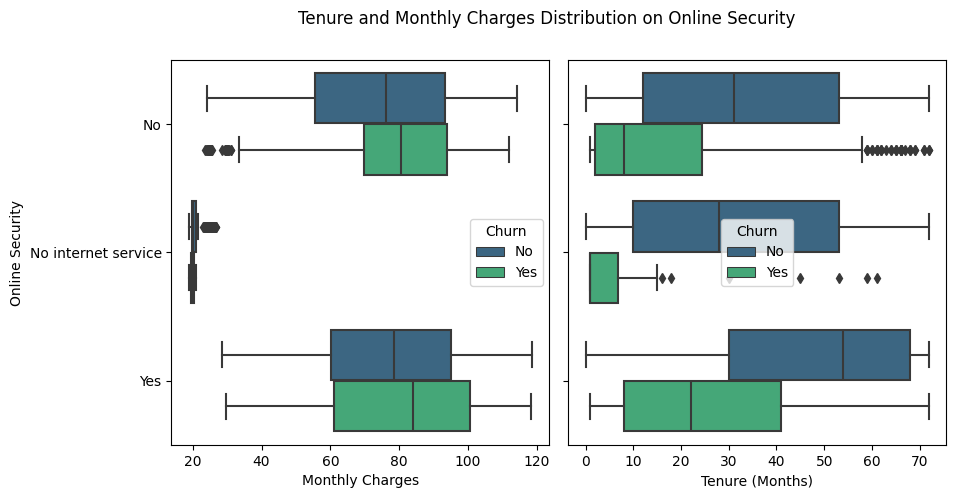

In [29]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Online Security')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['OnlineSecurity'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    box.set_ylabel('Online Security' if i == 0 else '')

It can be seen that there are outliers in certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. First of all, we examine the relationship between outliers and non-outliers in the `No` class of the `OnlineSecurity` feature based on the distribution of the special `MonthlyCharges` feature for churn customers.

In [30]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['OnlineSecurity','No'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService       36      1  DSL   36          975      2  Fiber optic   

                     Outliers  
                freq freq (%)  
InternetService  779    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `DSL` class of the `InternetService` feature. The percentage is even up to 100 % which indicates that there are no other classes in the outliers range because that range is the monthly fee for `DSL` services. Next, a visualization will be carried out to see the distribution.

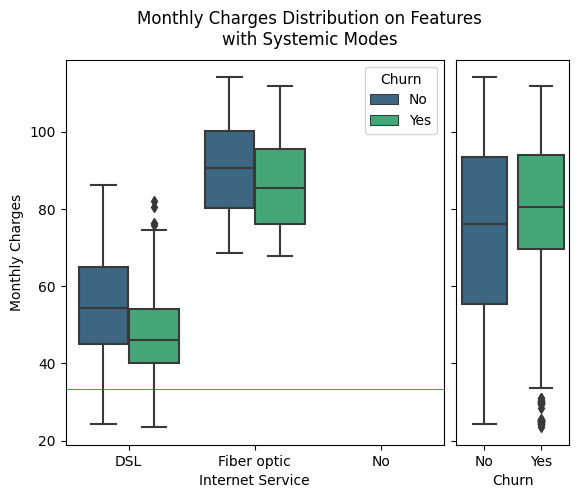

In [31]:
diff.box_plot()

It can be seen that values ​​that exceed lower outliers are not extreme values ​​for the `DSL` class of the `InternetService` feature. Therefore, no deletion will be carried out even if the value exceeds this limit. Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `OnlineSecurity` feature based on the distribution of the `MonthlyCharges` feature specifically for subscribers who are still subscribed.

In [32]:
diff = collective_outliers(
    churn='No',
    num_var='MonthlyCharges',
    on=['OnlineSecurity','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, we examine the relationship between outliers and non-outliers in the `No` class of the `OnlineSecurity` feature based on the distribution of `tenure` features specifically for churn customers.

In [33]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['OnlineSecurity','No'],
    upper_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                  \
                    count unique  top freq        count unique top freq   
OnlineBackup           37      2  Yes   30          974      2  No  741   
DeviceProtection       37      2  Yes   29          974      2  No  701   

                 Outliers  
                 freq (%)  
OnlineBackup        81.08  
DeviceProtection    78.38

It can be seen that there is a different mode as an indication of a systemic pattern, namely the `Yes` class of the `OnlineBackup` and `DeviceProtection` features. The percentages are respectively 81% and 78%. Next, a visualization will be carried out to see the distribution.

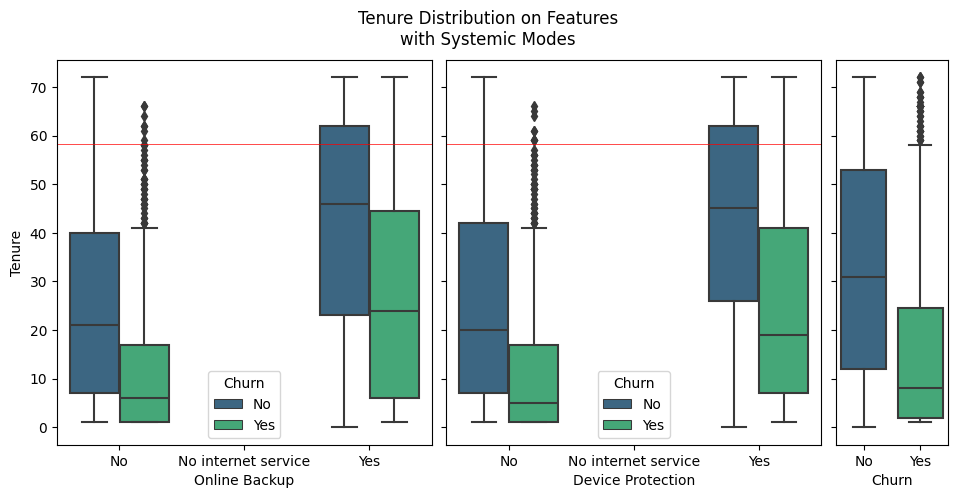

In [34]:
diff.box_plot()

It can be seen that there are extreme values ​​for the `No` class of the `OnlineBackup` and `DeviceProtection` features that go beyond the upper outliers line. Therefore, the deletion will only be carried out on the `No` class of the two features whose outliers values ​​are within the upper outliers range.

In [35]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['OnlineSecurity']=='No') &
    (
        (data['OnlineBackup']=='No') | 
        (data['DeviceProtection']=='No')
    )
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `OnlineSecurity` feature based on the distribution of the `tenure` feature specifically for churn customers.

In [36]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['OnlineSecurity','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, a descriptive statistical analysis of the `OnlineSecurity` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [37]:
data[data['Churn']=='Yes'].groupby('OnlineSecurity').describe().transpose()

OnlineSecurity                No  No internet service         Yes
tenure         count  997.000000            74.000000  201.000000
               mean    15.247743             6.662162   25.432836
               std     17.043643            12.707755   20.300658
               min      1.000000             1.000000    1.000000
               25%      2.000000             1.000000    8.000000
               50%      8.000000             1.000000   22.000000
               75%     24.000000             6.750000   41.000000
               max     72.000000            61.000000   72.000000
MonthlyCharges count  997.000000            74.000000  201.000000
               mean    77.184456            19.975676   81.471649
               std     20.204315             0.528129   22.553789
               min     23.450001            18.850000   29.700001
               25%     69.650002            19.612500   61.150002
               50%     80.400002            19.975000   84.099998
               75%     93.550003            20.250000  100.500000
               max    111.949997            21.049999  118.349998

Based on this analysis, the insight obtained can be described as follows:

1. Based on those who did not subscribe to the `OnlineSecurity` service, most of the customers who churn were those whose subscription duration was up to 24 months and the bills charged ranged from 65 to 95.

1. Based on those who subscribe to the `OnlineSecurity` service, most of the customers who churn are those whose subscription duration is up to 41 months and the bills charged range from 60 to 105.
1. Based on those who do not use the `InternetService` service, most customers who churn are those whose subscription duration is under 7 months and the bills charged range from 19 to 21.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of subscribers who churn were those who subscribed for up to 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases one could use class based analysis results from the `OnlineSecurity` feature.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `OnlineSecurity` feature when linked to the `tenure` and `MonthlyCharges` features. Furthermore, a descriptive statistical analysis of the `OnlineSecurity` feature will also be carried out to find out the mode value that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [38]:
for i in data['OnlineSecurity'].unique():
    desc = data[(data['Churn']=='Yes') & (data['OnlineSecurity']==i)][['tenure']].describe()
    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Online Security' if i == 'Yes' else
                "doesn't subscribe Online Security" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )
        
        stats = data[
            (data['Churn']=='Yes') & 
            (data['OnlineSecurity']==i) & 
            (thres)
        ].describe(include='category').transpose()
        
        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who doesn't subscribe Online Security whose Tenure is up to 24 months.


,count,unique,top,freq,freq (%)
Dependents,758,2,No,651,85.88
OnlineSecurity,758,1,No,758,100.00
OnlineBackup,758,2,No,623,82.19
InternetService,758,2,Fiber optic,557,73.48
DeviceProtection,758,2,No,586,77.31
TechSupport,758,2,No,677,89.31
Contract,758,2,Month-to-month,748,98.68
PaperlessBilling,758,2,Yes,584,77.04
Churn,758,1,Yes,758,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Online Security whose Tenure is more than 24 months.


,count,unique,top,freq,freq (%)
Dependents,239,2,No,190,79.50
OnlineSecurity,239,1,No,239,100.00
OnlineBackup,239,2,Yes,121,50.63
InternetService,239,2,Fiber optic,209,87.45
DeviceProtection,239,2,Yes,124,51.88
TechSupport,239,2,No,181,75.73
Contract,239,3,Month-to-month,186,77.82
PaperlessBilling,239,2,Yes,207,86.61
Churn,239,1,Yes,239,100.00



Descriptive Statistics on Customer Churn who subscribes Online Security whose Tenure is up to 41 months.


,count,unique,top,freq,freq (%)
Dependents,155,2,No,122,78.71
OnlineSecurity,155,1,Yes,155,100.00
OnlineBackup,155,2,No,106,68.39
InternetService,155,2,Fiber optic,86,55.48
DeviceProtection,155,2,No,109,70.32
TechSupport,155,2,No,110,70.97
Contract,155,2,Month-to-month,139,89.68
PaperlessBilling,155,2,Yes,108,69.68
Churn,155,1,Yes,155,100.00



Descriptive Statistics on Customer Churn who subscribes Online Security whose Tenure is more than 41 months.


,count,unique,top,freq,freq (%)
Dependents,46,2,No,35,76.09
OnlineSecurity,46,1,Yes,46,100.00
OnlineBackup,46,2,Yes,29,63.04
InternetService,46,2,Fiber optic,42,91.30
DeviceProtection,46,2,Yes,26,56.52
TechSupport,46,2,No,27,58.70
Contract,46,3,One year,20,43.48
PaperlessBilling,46,2,Yes,32,69.57
Churn,46,1,Yes,46,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is up to 6 months.


,count,unique,top,freq,freq (%)
Dependents,55,2,No,48,87.27
OnlineSecurity,55,1,No internet service,55,100.00
OnlineBackup,55,1,No internet service,55,100.00
InternetService,55,1,No,55,100.00
DeviceProtection,55,1,No internet service,55,100.00
TechSupport,55,1,No internet service,55,100.00
Contract,55,2,Month-to-month,54,98.18
PaperlessBilling,55,2,No,36,65.45
Churn,55,1,Yes,55,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is more than 6 months.


,count,unique,top,freq,freq (%)
Dependents,19,2,No,12,63.16
OnlineSecurity,19,1,No internet service,19,100.00
OnlineBackup,19,1,No internet service,19,100.00
InternetService,19,1,No,19,100.00
DeviceProtection,19,1,No internet service,19,100.00
TechSupport,19,1,No internet service,19,100.00
Contract,19,3,Month-to-month,14,73.68
PaperlessBilling,19,2,No,13,68.42
Churn,19,1,Yes,19,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which class of other features has the greatest chance of appearing and has the potential to cause customers to churn if it is linked to each class of `OnlineSecurity` features based on the distribution of `tenure` features. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [39]:
for i in data['OnlineSecurity'].unique():
    desc = data[(data['Churn']=='Yes') & (data['OnlineSecurity']==i)][['MonthlyCharges']].describe()
    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Online Security' if i == 'Yes' else
                "doesn't subscribe Online Security" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['OnlineSecurity']==i) & 
            (thres)
        ].describe(include='category').transpose()
        
        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who doesn't subscribe Online Security whose Monthly Charges is between 69.65 and 93.55.


,count,unique,top,freq,freq (%)
Dependents,501,2,No,425,84.83
OnlineSecurity,501,1,No,501,100.00
OnlineBackup,501,2,No,402,80.24
InternetService,501,2,Fiber optic,489,97.60
DeviceProtection,501,2,No,404,80.64
TechSupport,501,2,No,457,91.22
Contract,501,3,Month-to-month,486,97.01
PaperlessBilling,501,2,Yes,406,81.04
Churn,501,1,Yes,501,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Online Security whose Monthly Charges is less than 69.65 or more than 93.55.


,count,unique,top,freq,freq (%)
Dependents,496,2,No,416,83.87
OnlineSecurity,496,1,No,496,100.00
OnlineBackup,496,2,No,339,68.35
InternetService,496,2,Fiber optic,277,55.85
DeviceProtection,496,2,No,297,59.88
TechSupport,496,2,No,401,80.85
Contract,496,3,Month-to-month,448,90.32
PaperlessBilling,496,2,Yes,385,77.62
Churn,496,1,Yes,496,100.00



Descriptive Statistics on Customer Churn who subscribes Online Security whose Monthly Charges is between 61.15 and 100.5.


,count,unique,top,freq,freq (%)
Dependents,101,2,No,84,83.17
OnlineSecurity,101,1,Yes,101,100.00
OnlineBackup,101,2,No,69,68.32
InternetService,101,2,Fiber optic,78,77.23
DeviceProtection,101,2,No,73,72.28
TechSupport,101,2,No,73,72.28
Contract,101,3,Month-to-month,88,87.13
PaperlessBilling,101,2,Yes,72,71.29
Churn,101,1,Yes,101,100.00



Descriptive Statistics on Customer Churn who subscribes Online Security whose Monthly Charges is less than 61.15 or more than 100.5.


,count,unique,top,freq,freq (%)
Dependents,100,2,No,73,73.0
OnlineSecurity,100,1,Yes,100,100.0
OnlineBackup,100,2,No,54,54.0
InternetService,100,2,DSL,50,50.0
DeviceProtection,100,2,No,56,56.0
TechSupport,100,2,No,64,64.0
Contract,100,3,Month-to-month,69,69.0
PaperlessBilling,100,2,Yes,68,68.0
Churn,100,1,Yes,100,100.0



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is between 19.61 and 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,2,Month-to-month,34,91.89
PaperlessBilling,37,2,No,26,70.27
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is less than 19.61 or more than 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,3,Month-to-month,34,91.89
PaperlessBilling,37,2,No,23,62.16
Churn,37,1,Yes,37,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which class of other features has the greatest chance of appearing and has the potential to cause customers to churn if it is linked to each class of the `OnlineSecurity` feature based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Online Backup Feature**

Next, a boxplot visualization will be performed to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `OnlineBackup` feature.

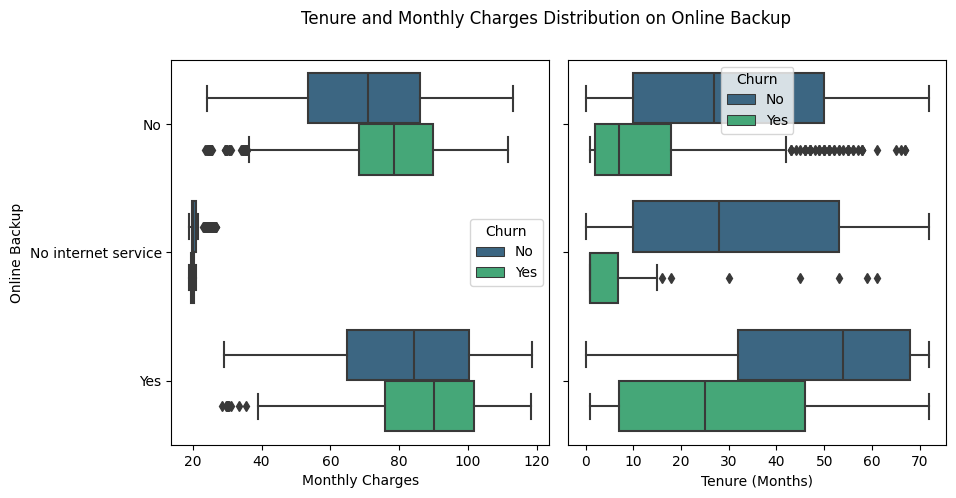

In [40]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Online Backup')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['OnlineBackup'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    box.set_ylabel('Online Backup' if i == 0 else '')

It can be seen that there are outliers for certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. First of all, we examine the relationship between outliers and non-outliers in the `No` class of the `OnlineBackup` feature based on the distribution of the special `MonthlyCharges` feature for churn customers.

In [41]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['OnlineBackup','No'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService       44      1  DSL   44          820      2  Fiber optic   

                     Outliers  
                freq freq (%)  
InternetService  636    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `DSL` class of the `InternetService` feature. The percentage is even up to 100 % which indicates that there are no other classes in the outliers range because that range is the monthly fee for `DSL` services. Next, a visualization will be carried out to see the distribution.

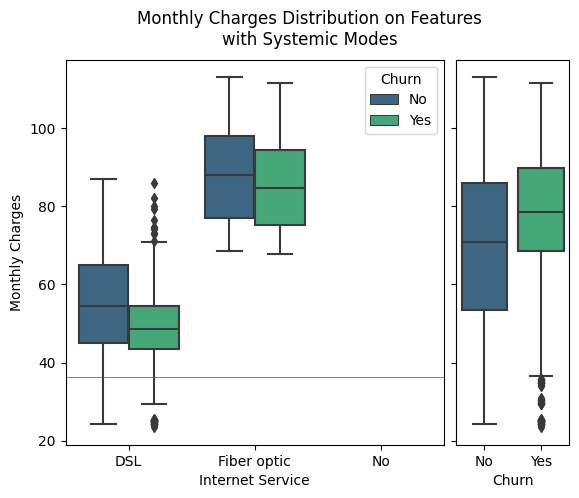

In [42]:
diff.box_plot()

It was found that there are outliersand on-outliers values ​​in the `DSL` class of the `InternetService` feature that exceed the red lower outliers line. Therefore, handling will only be carried out for values ​​that are outliers because they can affect machine learning decisions in that range of values.

In [43]:
desc = data[
    (data['Churn']=='Yes') & 
    (data['OnlineBackup']=='No') & 
    (data['InternetService']=='DSL')
]['MonthlyCharges'].describe() 

lower_outliers = desc['25%'] - (1.5*(desc['75%'] - desc['25%']))
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<lower_outliers) & 
    (data['InternetService']=='DSL') &
    (data['OnlineBackup']=='No')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `OnlineBackup` feature based on the distribution of the `MonthlyCharges` feature specifically for subscribers who are still subscribed.

In [44]:
diff = collective_outliers(
    churn='No',
    num_var='MonthlyCharges',
    on=['OnlineBackup','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, we examine the relationship between outliers and non-outliers in the `Yes` class of the `OnlineBackup` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [45]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['OnlineBackup','Yes'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService       10      1  DSL   10          324      2  Fiber optic   

                     Outliers  
                freq freq (%)  
InternetService  258    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `DSL` class of the `InternetService` feature. The percentage is even up to 100 % which indicates that there are no other classes in the outliers range because that range is the monthly fee for `DSL` services. Next, a visualization will be carried out to see the distribution.

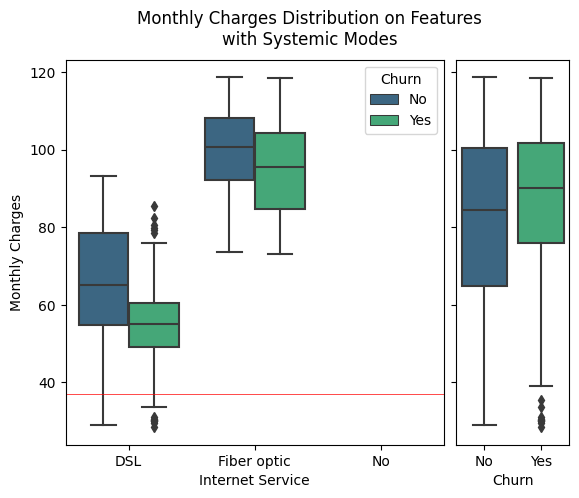

In [46]:
diff.box_plot()

It was found that outliers and non-outliers for class `DSL` of the `InternetService` feature exceeded the red lower outliers line. Therefore, handling will only be carried out for values ​​that are outliers because they can affect machine learning decisions in that range of values.

In [47]:
desc = data[
    (data['Churn']=='Yes') & 
    (data['OnlineBackup']=='Yes') & 
    (data['InternetService']=='DSL')
]['MonthlyCharges'].describe()

lower_outliers = desc['25%'] - (1.5*(desc['75%'] - desc['25%']))
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<lower_outliers) & 
    (data['InternetService']=='DSL') &
    (data['OnlineBackup']=='Yes')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No` class of the `OnlineBackup` feature based on the distribution of `tenure` features specifically for churn customers.

In [48]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['OnlineBackup','No'],
    upper_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                  \
                    count unique  top freq        count unique top freq   
DeviceProtection       42      2  Yes   24          800      2  No  605   

                 Outliers  
                 freq (%)  
DeviceProtection    57.14

It can be seen that there is a difference in mode as an indication of a systemic pattern, namely the `Yes` class of the `DeviceProtection` feature with a percentage of 57%. Next, a visualization will be carried out to see the distribution.

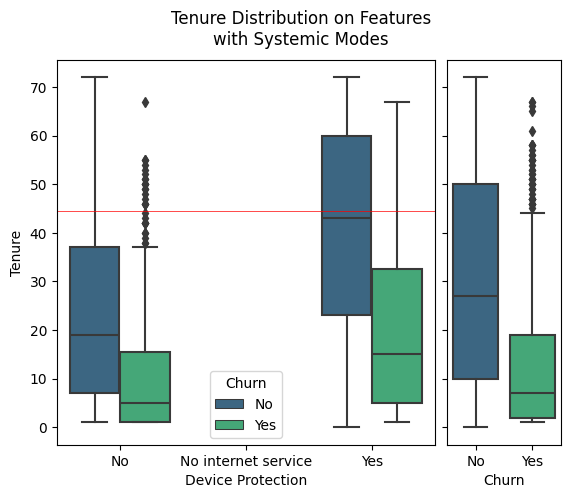

In [49]:
diff.box_plot()

It was found that there are outliers values ​​for class `No` from the `DeviceProtection` feature that exceed the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions in that range of values.

In [50]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['OnlineBackup']=='No') &
    (data['DeviceProtection']=='No')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `OnlineBackup` feature based on the distribution of `tenure` features specifically for churn customers.

In [51]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['OnlineBackup','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, a descriptive statistical analysis of the `OnlineBackup` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [52]:
data[data['Churn']=='Yes'].groupby('OnlineBackup').describe().transpose()

OnlineBackup                  No  No internet service         Yes
tenure         count  824.000000            74.000000  326.000000
               mean    11.990291             6.662162   28.705521
               std     13.216393            12.707755   21.627456
               min      1.000000             1.000000    1.000000
               25%      2.000000             1.000000    7.000000
               50%      7.000000             1.000000   25.500000
               75%     18.000000             6.750000   46.000000
               max     67.000000            61.000000   72.000000
MonthlyCharges count  824.000000            74.000000  326.000000
               mean    75.903160            19.975676   87.100929
               std     18.397303             0.528129   19.054932
               min     29.400000            18.850000   33.549999
               25%     69.237499            19.612500   78.637499
               50%     78.750000            19.975000   90.825001
               75%     89.900002            20.250000  101.975000
               max    111.599998            21.049999  118.349998

Based on this analysis, the insight obtained can be described as follows:

1. Based on those who did not subscribe to the `OnlineBackup` service, most of the customers who churn were those whose subscription duration was up to 18 months and the bills charged ranged from 65 to 90.

1. Based on those who subscribe to the `OnlineBackup` service, most of the customers who churn are those whose subscription duration is up to 46 months and the bills charged range from 75 to 105.
1. Based on those who do not use the `InternetService` service, most customers who churn are those whose subscription duration is up to 7 months and the bills charged range from 19 to 21.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of subscribers who churn were those who subscribed for under 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases, it can be using class-based analysis results from the `OnlineBackup` tool.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `OnlineBackup` feature as compared to the `tenure` and `MonthlyCharges` features. Furthermore, a descriptive statistical analysis of the `OnlineBackup` feature will also be carried out to find out the value of the mode that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [53]:
for i in data['OnlineBackup'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['OnlineBackup']==i)
    ][['tenure']].describe()

    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Online Backup' if i == 'Yes' else
                "doesn't subscribe Online Backup" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['OnlineBackup']==i) & 
            (thres)
        ].describe(include='category').transpose()
        
        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who doesn't subscribe Online Backup whose Tenure is up to 18 months.


,count,unique,top,freq,freq (%)
Dependents,630,2,No,539,85.56
OnlineSecurity,630,2,No,559,88.73
OnlineBackup,630,1,No,630,100.00
InternetService,630,2,Fiber optic,454,72.06
DeviceProtection,630,2,No,500,79.37
TechSupport,630,2,No,559,88.73
Contract,630,2,Month-to-month,622,98.73
PaperlessBilling,630,2,Yes,468,74.29
Churn,630,1,Yes,630,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Online Backup whose Tenure is more than 18 months.


,count,unique,top,freq,freq (%)
Dependents,194,2,No,157,80.93
OnlineSecurity,194,2,No,148,76.29
OnlineBackup,194,1,No,194,100.00
InternetService,194,2,Fiber optic,164,84.54
DeviceProtection,194,2,No,105,54.12
TechSupport,194,2,No,145,74.74
Contract,194,3,Month-to-month,164,84.54
PaperlessBilling,194,2,Yes,167,86.08
Churn,194,1,Yes,194,100.00



Descriptive Statistics on Customer Churn who subscribes Online Backup whose Tenure is up to 46 months.


,count,unique,top,freq,freq (%)
Dependents,245,2,No,202,82.45
OnlineSecurity,245,2,No,192,78.37
OnlineBackup,245,1,Yes,245,100.00
InternetService,245,2,Fiber optic,190,77.55
DeviceProtection,245,2,No,153,62.45
TechSupport,245,2,No,195,79.59
Contract,245,3,Month-to-month,225,91.84
PaperlessBilling,245,2,Yes,201,82.04
Churn,245,1,Yes,245,100.00



Descriptive Statistics on Customer Churn who subscribes Online Backup whose Tenure is more than 46 months.


,count,unique,top,freq,freq (%)
Dependents,81,2,No,62,76.54
OnlineSecurity,81,2,No,56,69.14
OnlineBackup,81,1,Yes,81,100.00
InternetService,81,2,Fiber optic,68,83.95
DeviceProtection,81,2,Yes,57,70.37
TechSupport,81,2,No,51,62.96
Contract,81,3,Month-to-month,35,43.21
PaperlessBilling,81,2,Yes,64,79.01
Churn,81,1,Yes,81,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is up to 6 months.


,count,unique,top,freq,freq (%)
Dependents,55,2,No,48,87.27
OnlineSecurity,55,1,No internet service,55,100.00
OnlineBackup,55,1,No internet service,55,100.00
InternetService,55,1,No,55,100.00
DeviceProtection,55,1,No internet service,55,100.00
TechSupport,55,1,No internet service,55,100.00
Contract,55,2,Month-to-month,54,98.18
PaperlessBilling,55,2,No,36,65.45
Churn,55,1,Yes,55,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is more than 6 months.


,count,unique,top,freq,freq (%)
Dependents,19,2,No,12,63.16
OnlineSecurity,19,1,No internet service,19,100.00
OnlineBackup,19,1,No internet service,19,100.00
InternetService,19,1,No,19,100.00
DeviceProtection,19,1,No internet service,19,100.00
TechSupport,19,1,No internet service,19,100.00
Contract,19,3,Month-to-month,14,73.68
PaperlessBilling,19,2,No,13,68.42
Churn,19,1,Yes,19,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `OnlineBackup` feature which has great potential to cause customers to churn based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [54]:
for i in data['OnlineBackup'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['OnlineBackup']==i)
    ][['MonthlyCharges']].describe()
    
    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Online Backup' if i == 'Yes' else
                "doesn't subscribe Online Backup" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['OnlineBackup']==i) & 
            (thres)
        ].describe(include='category').transpose()
        
        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who doesn't subscribe Online Backup whose Monthly Charges is between 69.24 and 89.9.


,count,unique,top,freq,freq (%)
Dependents,413,2,No,360,87.17
OnlineSecurity,413,2,No,378,91.53
OnlineBackup,413,1,No,413,100.00
InternetService,413,2,Fiber optic,399,96.61
DeviceProtection,413,2,No,343,83.05
TechSupport,413,2,No,379,91.77
Contract,413,3,Month-to-month,404,97.82
PaperlessBilling,413,2,Yes,330,79.90
Churn,413,1,Yes,413,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Online Backup whose Monthly Charges is less than 69.24 or more than 89.9.


,count,unique,top,freq,freq (%)
Dependents,411,2,No,336,81.75
OnlineSecurity,411,2,No,329,80.05
OnlineBackup,411,1,No,411,100.00
InternetService,411,2,Fiber optic,219,53.28
DeviceProtection,411,2,No,262,63.75
TechSupport,411,2,No,325,79.08
Contract,411,3,Month-to-month,382,92.94
PaperlessBilling,411,2,Yes,305,74.21
Churn,411,1,Yes,411,100.00



Descriptive Statistics on Customer Churn who subscribes Online Backup whose Monthly Charges is between 78.64 and 101.98.


,count,unique,top,freq,freq (%)
Dependents,162,2,No,132,81.48
OnlineSecurity,162,2,No,137,84.57
OnlineBackup,162,1,Yes,162,100.00
InternetService,162,2,Fiber optic,157,96.91
DeviceProtection,162,2,No,102,62.96
TechSupport,162,2,No,138,85.19
Contract,162,3,Month-to-month,150,92.59
PaperlessBilling,162,2,Yes,135,83.33
Churn,162,1,Yes,162,100.00



Descriptive Statistics on Customer Churn who subscribes Online Backup whose Monthly Charges is less than 78.64 or more than 101.98.


,count,unique,top,freq,freq (%)
Dependents,164,2,No,132,80.49
OnlineSecurity,164,2,No,111,67.68
OnlineBackup,164,1,Yes,164,100.00
InternetService,164,2,Fiber optic,101,61.59
DeviceProtection,164,2,Yes,89,54.27
TechSupport,164,2,No,108,65.85
Contract,164,3,Month-to-month,110,67.07
PaperlessBilling,164,2,Yes,130,79.27
Churn,164,1,Yes,164,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is between 19.61 and 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,2,Month-to-month,34,91.89
PaperlessBilling,37,2,No,26,70.27
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is less than 19.61 or more than 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,3,Month-to-month,34,91.89
PaperlessBilling,37,2,No,23,62.16
Churn,37,1,Yes,37,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `OnlineBackup` feature which has a great potential to cause customers to churn based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Device Protection Features**

Next, a boxplot visualization will be performed to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `DeviceProtection` feature.

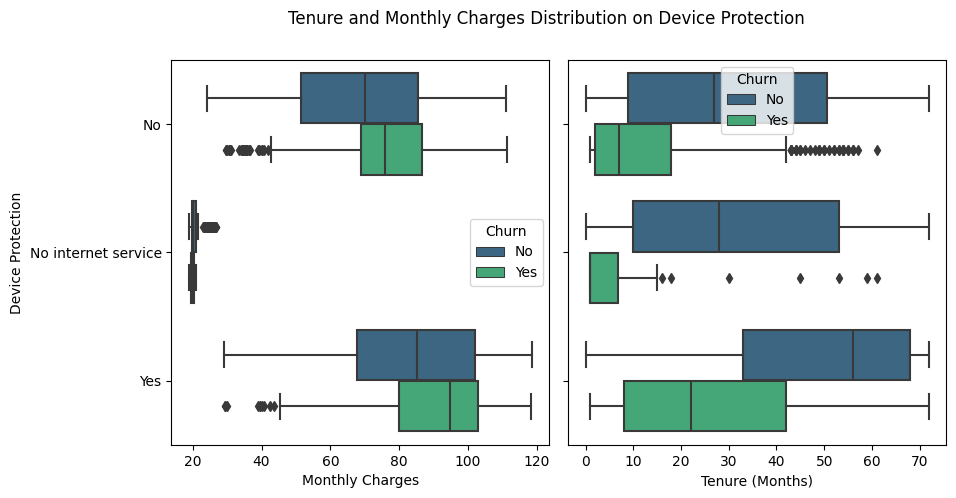

In [55]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Device Protection')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['DeviceProtection'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    box.set_ylabel('Device Protection' if i == 0 else '')

It can be seen that there are outliers for certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. First of all, we examine the relationship between outliers and non-outliers in the `No` class of the `DeviceProtection` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [56]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['DeviceProtection','No'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService       32      1  DSL   32          750      2  Fiber optic   

                     Outliers  
                freq freq (%)  
InternetService  583    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `DSL` class of the `InternetService` feature. The percentage is even up to 100 % which indicates that there are no other classes in the outliers range because that range is the monthly fee for `DSL` services. Next, a visualization will be carried out to see the distribution.

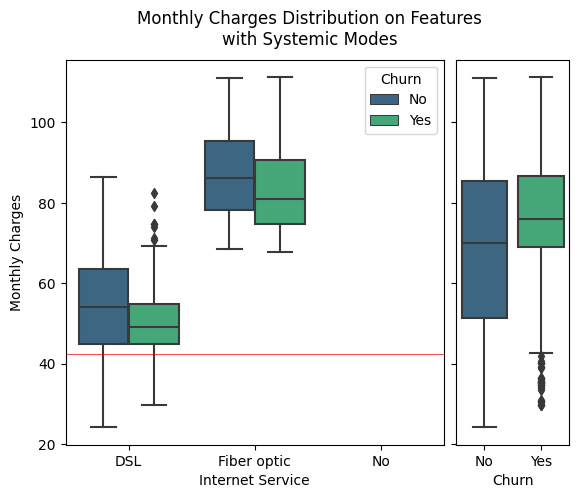

In [57]:
diff.box_plot()

It can be seen that values ​​that exceed lower outliers are not extreme values ​​for the `DSL` class of the `InternetService` feature. Therefore, no deletion will be carried out even if the value exceeds this limit. Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `DeviceProtection` feature based on the distribution of the `MonthlyCharges` feature specifically for subscribers who are still subscribed.

In [58]:
diff = collective_outliers(
    churn='No',
    num_var='MonthlyCharges',
    on=['DeviceProtection','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, we examine the relationship between outliers and non-outliers in the `Yes` class of the `DeviceProtection` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [59]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['DeviceProtection','Yes'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService       10      1  DSL   10          358      2  Fiber optic   

                     Outliers  
                freq freq (%)  
InternetService  293    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `DSL` class of the `InternetService` feature. The percentage is even up to 100 % which indicates that there are no other classes in the outliers range because that range is the monthly fee for `DSL` services. Next, a visualization will be carried out to see the distribution.

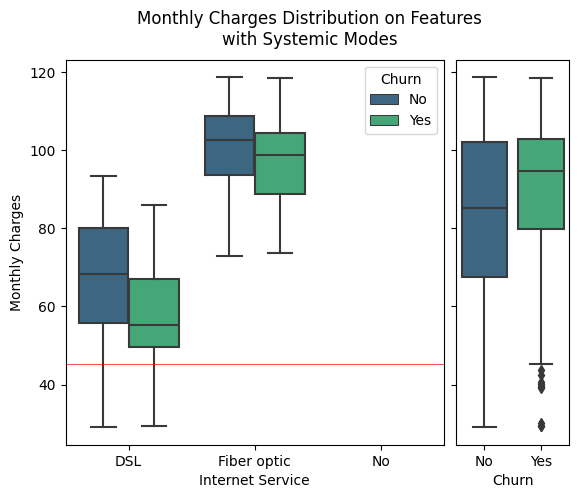

In [60]:
diff.box_plot()

It can be seen that values ​​that exceed lower outliers are not extreme values ​​for the `DSL` class of the `InternetService` feature. Therefore, no deletion will be carried out even if the value exceeds this limit. Next, we examine the relationship between outliers and non-outliers in the `No` class of the `DeviceProtection` feature based on the distribution of `tenure` features specifically for churn customers.

In [61]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['DeviceProtection','No'],
    upper_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                 Outliers
                count unique  top freq        count unique top freq freq (%)
OnlineBackup       35      2  Yes   33          747      2  No  603    94.29

It can be seen that there is a difference in mode as an indication of a systemic pattern, namely the `Yes` class of the `OnlineBackup` feature, which has a percentage of 94%. Next, a visualization will be carried out to see the distribution.

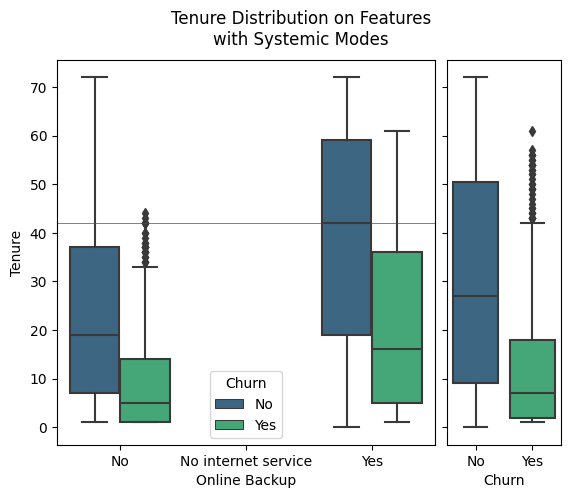

In [62]:
diff.box_plot()

It was found that there are outliers values ​​for class `No` from the `OnlineBackup` feature that exceed the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions in that range of values.

In [63]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['OnlineBackup']=='No') &
    (data['DeviceProtection']=='No')
].index.values

data = data.drop(index=idx)

Next, we will examine the relationship between outliers and non-outliers in the `No internet service` class of the `DeviceProtection` feature based on the distribution of `tenure` features specifically for churn customers.

In [64]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['DeviceProtection','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, a descriptive statistical analysis of the `DeviceProtection` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [65]:
data[data['Churn']=='Yes'].groupby('DeviceProtection').describe().transpose()

DeviceProtection              No  No internet service         Yes
tenure         count  780.000000            74.000000  368.000000
               mean    11.914103             6.662162   26.788043
               std     13.340762            12.707755   21.244744
               min      1.000000             1.000000    1.000000
               25%      2.000000             1.000000    8.000000
               50%      7.000000             1.000000   22.000000
               75%     18.000000             6.750000   42.000000
               max     61.000000            61.000000   72.000000
MonthlyCharges count  780.000000            74.000000  368.000000
               mean    74.555000            19.975676   88.627449
               std     17.664816             0.528129   19.032673
               min     29.700001            18.850000   29.400000
               25%     68.874998            19.612500   79.887501
               50%     76.000000            19.975000   94.774998
               75%     86.562502            20.250000  102.962498
               max    111.250000            21.049999  118.349998

Based on this analysis, the insight obtained can be described as follows:

1. Based on those who did not subscribe to the `DeviceProtection` service, most of the customers who churn were those whose subscription duration was up to 18 months and the bills charged ranged from 65 to 90.

1. Based on those who subscribe to the `OnlineBackup` service, most of the customers who churn are those whose subscription duration is up to 42 months and the bills charged range from 75 to 105.
1. Based on those who do not use the `InternetService` service, most customers who churn are those whose subscription duration is up to 7 months and the bills charged range from 19 to 21.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of subscribers who churn were those who subscribed for under 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases, it can be using class-based analysis results from the `DeviceProtection` feature.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `DeviceProtection` feature when associated with the `tenure` and `MonthlyCharges` features. Furthermore, a descriptive statistical analysis of the `DeviceProtection` feature will also be carried out to find out the value of the mode that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [66]:
for i in data['DeviceProtection'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['DeviceProtection']==i)
    ][['tenure']].describe()
    
    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Device Protection' if i == 'Yes' else
                "doesn't subscribe Device Protection" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['DeviceProtection']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who subscribes Device Protection whose Tenure is up to 42 months.


,count,unique,top,freq,freq (%)
Dependents,278,2,No,223,80.22
OnlineSecurity,278,2,No,231,83.09
OnlineBackup,278,2,No,193,69.42
InternetService,278,2,Fiber optic,213,76.62
DeviceProtection,278,1,Yes,278,100.00
TechSupport,278,2,No,216,77.70
Contract,278,3,Month-to-month,252,90.65
PaperlessBilling,278,2,Yes,219,78.78
Churn,278,1,Yes,278,100.00



Descriptive Statistics on Customer Churn who subscribes Device Protection whose Tenure is more than 42 months.


,count,unique,top,freq,freq (%)
Dependents,90,2,No,72,80.00
OnlineSecurity,90,2,No,65,72.22
OnlineBackup,90,2,Yes,64,71.11
InternetService,90,2,Fiber optic,80,88.89
DeviceProtection,90,1,Yes,90,100.00
TechSupport,90,2,No,55,61.11
Contract,90,3,Month-to-month,43,47.78
PaperlessBilling,90,2,Yes,76,84.44
Churn,90,1,Yes,90,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is up to 6 months.


,count,unique,top,freq,freq (%)
Dependents,55,2,No,48,87.27
OnlineSecurity,55,1,No internet service,55,100.00
OnlineBackup,55,1,No internet service,55,100.00
InternetService,55,1,No,55,100.00
DeviceProtection,55,1,No internet service,55,100.00
TechSupport,55,1,No internet service,55,100.00
Contract,55,2,Month-to-month,54,98.18
PaperlessBilling,55,2,No,36,65.45
Churn,55,1,Yes,55,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is more than 6 months.


,count,unique,top,freq,freq (%)
Dependents,19,2,No,12,63.16
OnlineSecurity,19,1,No internet service,19,100.00
OnlineBackup,19,1,No internet service,19,100.00
InternetService,19,1,No,19,100.00
DeviceProtection,19,1,No internet service,19,100.00
TechSupport,19,1,No internet service,19,100.00
Contract,19,3,Month-to-month,14,73.68
PaperlessBilling,19,2,No,13,68.42
Churn,19,1,Yes,19,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Device Protection whose Tenure is up to 18 months.


,count,unique,top,freq,freq (%)
Dependents,594,2,No,513,86.36
OnlineSecurity,594,2,No,521,87.71
OnlineBackup,594,2,No,500,84.18
InternetService,594,2,Fiber optic,429,72.22
DeviceProtection,594,1,No,594,100.00
TechSupport,594,2,No,530,89.23
Contract,594,2,Month-to-month,589,99.16
PaperlessBilling,594,2,Yes,447,75.25
Churn,594,1,Yes,594,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Device Protection whose Tenure is more than 18 months.


,count,unique,top,freq,freq (%)
Dependents,186,2,No,150,80.65
OnlineSecurity,186,2,No,137,73.66
OnlineBackup,186,2,No,103,55.38
InternetService,186,2,Fiber optic,152,81.72
DeviceProtection,186,1,No,186,100.00
TechSupport,186,2,No,147,79.03
Contract,186,3,Month-to-month,160,86.02
PaperlessBilling,186,2,Yes,156,83.87
Churn,186,1,Yes,186,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `DeviceProtection` feature which has great potential to cause customers to churn based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [67]:
for i in data['DeviceProtection'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['DeviceProtection']==i)
    ][['MonthlyCharges']].describe()
    
    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Device Protection' if i == 'Yes' else
                "doesn't subscribe Device Protection" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['DeviceProtection']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who subscribes Device Protection whose Monthly Charges is between 79.89 and 102.96.


,count,unique,top,freq,freq (%)
Dependents,184,2,No,144,78.26
OnlineSecurity,184,2,No,162,88.04
OnlineBackup,184,2,No,124,67.39
InternetService,184,2,Fiber optic,178,96.74
DeviceProtection,184,1,Yes,184,100.00
TechSupport,184,2,No,151,82.07
Contract,184,3,Month-to-month,165,89.67
PaperlessBilling,184,2,Yes,154,83.70
Churn,184,1,Yes,184,100.00



Descriptive Statistics on Customer Churn who subscribes Device Protection whose Monthly Charges is less than 79.89 or more than 102.96.


,count,unique,top,freq,freq (%)
Dependents,184,2,No,151,82.07
OnlineSecurity,184,2,No,134,72.83
OnlineBackup,184,2,No,95,51.63
InternetService,184,2,Fiber optic,115,62.50
DeviceProtection,184,1,Yes,184,100.00
TechSupport,184,2,No,120,65.22
Contract,184,3,Month-to-month,130,70.65
PaperlessBilling,184,2,Yes,141,76.63
Churn,184,1,Yes,184,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is between 19.61 and 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,2,Month-to-month,34,91.89
PaperlessBilling,37,2,No,26,70.27
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is less than 19.61 or more than 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,3,Month-to-month,34,91.89
PaperlessBilling,37,2,No,23,62.16
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Device Protection whose Monthly Charges is between 68.87 and 86.56.


,count,unique,top,freq,freq (%)
Dependents,390,2,No,341,87.44
OnlineSecurity,390,2,No,355,91.03
OnlineBackup,390,2,No,329,84.36
InternetService,390,2,Fiber optic,382,97.95
DeviceProtection,390,1,No,390,100.00
TechSupport,390,2,No,368,94.36
Contract,390,2,Month-to-month,387,99.23
PaperlessBilling,390,2,Yes,317,81.28
Churn,390,1,Yes,390,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Device Protection whose Monthly Charges is less than 68.87 or more than 86.56.


,count,unique,top,freq,freq (%)
Dependents,390,2,No,322,82.56
OnlineSecurity,390,2,No,303,77.69
OnlineBackup,390,2,No,274,70.26
InternetService,390,2,Fiber optic,199,51.03
DeviceProtection,390,1,No,390,100.00
TechSupport,390,2,No,309,79.23
Contract,390,3,Month-to-month,362,92.82
PaperlessBilling,390,2,Yes,286,73.33
Churn,390,1,Yes,390,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `DeviceProtection` feature which has great potential to cause customers to churn based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Tech Support Feature**

Next, a boxplot visualization will be performed to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `TechSupport` feature.

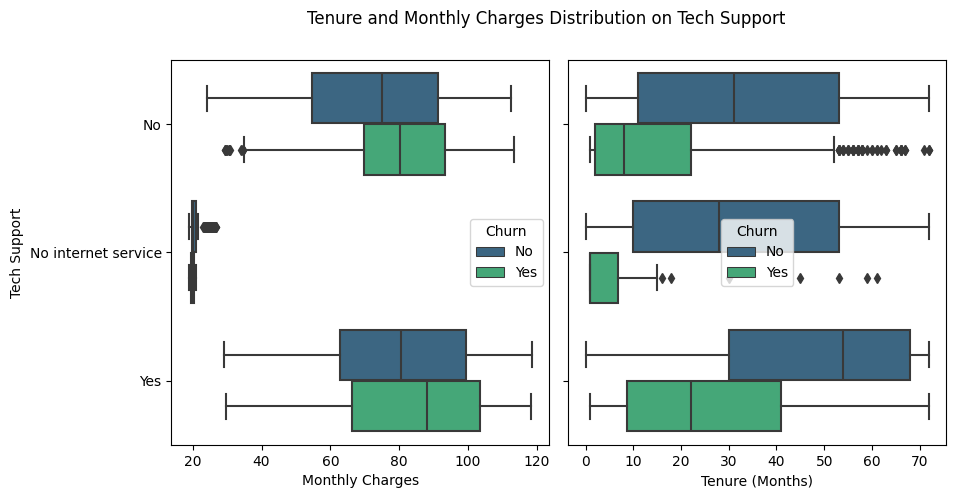

In [68]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Tech Support')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['TechSupport'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    box.set_ylabel('Tech Support' if i == 0 else '')

It can be seen that there are outliers for certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. We will first examine the outliers and non-outliers relationships in the `No` class of the `TechSupport` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [69]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['TechSupport','No'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService       11      1  DSL   11          937      2  Fiber optic   

                     Outliers  
                freq freq (%)  
InternetService  748    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `DSL` class of the `InternetService` feature. The percentage is even up to 100 % which indicates that there are no other classes in the outliers range because that range is the monthly fee for `DSL` services. Next, a visualization will be carried out to see the distribution.

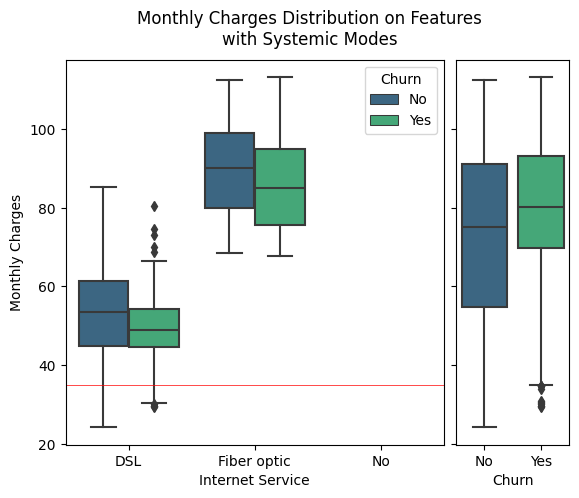

In [70]:
diff.box_plot()

Outliers and non-outliers values ​​that exceed the red lower outliers line are found in the `DSL` class of the `InternetService` feature. Therefore, handling will be carried out selectively for values ​​that are outliers in the `DSL` class of the `InternetService` feature which fall below the lower outliers limit.

In [71]:
desc = data[
    (data['Churn']=='Yes') & 
    (data['TechSupport']=='No') & 
    (data['InternetService']=='DSL')
]['MonthlyCharges'].describe() 

lower_outliers = desc['25%'] - (1.5*(desc['75%'] - desc['25%']))
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<lower_outliers) & 
    (data['InternetService']=='DSL') &
    (data['TechSupport']=='No')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `TechSupport` feature based on the distribution of the `MonthlyCharges` feature specifically for subscribers who are still subscribed.

In [72]:
diff = collective_outliers(
    churn='No',
    num_var='MonthlyCharges',
    on=['TechSupport','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, we examine the relationship between outliers and non-outliers in the `No` class of `TechSupport` features based on the distribution of `tenure` features specifically for churn customers.

In [73]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['TechSupport','No'],
    upper_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                  \
                    count unique  top freq        count unique top freq   
OnlineBackup           46      2  Yes   38          898      2  No  690   
DeviceProtection       46      2  Yes   36          898      2  No  666   

                 Outliers  
                 freq (%)  
OnlineBackup        82.61  
DeviceProtection    78.26

It can be seen that there is a difference in mode as an indication of a systemic pattern, namely the `Yes` class of the `OnlineBackup` and `DeviceProtection` features whose percentages are 83 % and 78 % respectively. Next, a visualization will be carried out to see the distribution.

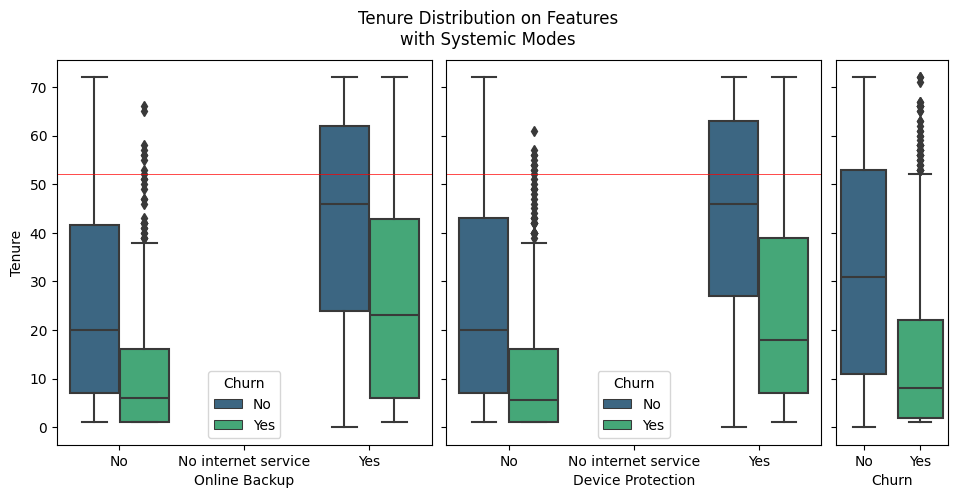

In [74]:
diff.box_plot()

It was found that outliers for the class `No` of the `OnlineBackup` and `DeviceProtection` features exceeded the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions in that range of values.

In [75]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['TechSupport']=='No') &
    (
        (data['OnlineBackup']=='No') | 
        (data['DeviceProtection']=='No')
    )
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No internet service` class of the `TechSupport` feature based on the distribution of `tenure` features specifically for churn customers.

In [76]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['TechSupport','No internet service'],
    upper_outliers=True
)

diff.get_table()

Empty DataFrame
Columns: [(Outliers, count), (Outliers, unique), (Outliers, top), (Outliers, freq), (Non-Outliers, count), (Non-Outliers, unique), (Non-Outliers, top), (Non-Outliers, freq), (Outliers, freq (%))]
Index: []

There was no difference in mode between outliers and non-outliers in any other features. Therefore, the process of handling outliers is not necessary. Next, a descriptive statistical analysis of the `TechSupport` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [77]:
data[data['Churn']=='Yes'].groupby('TechSupport').describe().transpose()

TechSupport                   No  No internet service         Yes
tenure         count  926.000000            74.000000  200.000000
               mean    13.807775             6.662162   26.430000
               std     15.352147            12.707755   20.689742
               min      1.000000             1.000000    1.000000
               25%      2.000000             1.000000    8.750000
               50%      8.000000             1.000000   22.000000
               75%     21.000000             6.750000   41.000000
               max     72.000000            61.000000   72.000000
MonthlyCharges count  926.000000            74.000000  200.000000
               mean    77.891037            19.975676   84.445251
               std     18.171587             0.528129   21.827682
               min     30.450001            18.850000   29.700001
               25%     69.862499            19.612500   66.324999
               50%     80.174999            19.975000   87.950001
               75%     91.400002            20.250000  103.449999
               max    113.199997            21.049999  118.349998

Based on this analysis, the insight obtained can be described as follows:

1. Based on those who did not subscribe to the `TechSupport` service, most of the customers who churn were those with a subscription duration of up to 21 months and bills charged ranging from 65 to 95.

1. Based on those who subscribe to the `TechSupport` service, most of the subscribers churn are those whose subscription duration is up to 41 months and the bills charged range from 65 to 105.
1. Based on those who do not use the `InternetService` service, most customers who churn are those whose subscription duration is under 7 months and the bills charged range from 19 to 21.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of customers who churn were those who subscribed for under 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases, it can be using class-based analysis results from the `TechSupport` tool.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `TechSupport` feature as compared to the `tenure` and `MonthlyCharges` features. Furthermore, descriptive statistical analysis of the `TechSupport` feature will also be carried out to find out the value of the mode that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [78]:
for i in data['TechSupport'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['TechSupport']==i)
    ][['tenure']].describe()

    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Tech Support' if i == 'Yes' else
                "doesn't subscribe Tech Support" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['TechSupport']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who subscribes Tech Support whose Tenure is up to 41 months.


,count,unique,top,freq,freq (%)
Dependents,153,2,No,120,78.43
OnlineSecurity,153,2,No,108,70.59
OnlineBackup,153,2,No,110,71.90
InternetService,153,2,Fiber optic,87,56.86
DeviceProtection,153,2,No,93,60.78
TechSupport,153,1,Yes,153,100.00
Contract,153,3,Month-to-month,129,84.31
PaperlessBilling,153,2,Yes,111,72.55
Churn,153,1,Yes,153,100.00



Descriptive Statistics on Customer Churn who subscribes Tech Support whose Tenure is more than 41 months.


,count,unique,top,freq,freq (%)
Dependents,47,2,No,38,80.85
OnlineSecurity,47,2,No,29,61.70
OnlineBackup,47,2,Yes,37,78.72
InternetService,47,2,Fiber optic,39,82.98
DeviceProtection,47,2,Yes,37,78.72
TechSupport,47,1,Yes,47,100.00
Contract,47,3,One year,23,48.94
PaperlessBilling,47,2,Yes,33,70.21
Churn,47,1,Yes,47,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Tech Support whose Tenure is up to 21 months.


,count,unique,top,freq,freq (%)
Dependents,696,2,No,601,86.35
OnlineSecurity,696,2,No,620,89.08
OnlineBackup,696,2,No,580,83.33
InternetService,696,2,Fiber optic,535,76.87
DeviceProtection,696,2,No,549,78.88
TechSupport,696,1,No,696,100.00
Contract,696,2,Month-to-month,691,99.28
PaperlessBilling,696,2,Yes,537,77.16
Churn,696,1,Yes,696,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Tech Support whose Tenure is more than 21 months.


,count,unique,top,freq,freq (%)
Dependents,230,2,No,182,79.13
OnlineSecurity,230,2,No,182,79.13
OnlineBackup,230,2,Yes,120,52.17
InternetService,230,2,Fiber optic,197,85.65
DeviceProtection,230,2,No,117,50.87
TechSupport,230,1,No,230,100.00
Contract,230,3,Month-to-month,196,85.22
PaperlessBilling,230,2,Yes,201,87.39
Churn,230,1,Yes,230,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is up to 6 months.


,count,unique,top,freq,freq (%)
Dependents,55,2,No,48,87.27
OnlineSecurity,55,1,No internet service,55,100.00
OnlineBackup,55,1,No internet service,55,100.00
InternetService,55,1,No,55,100.00
DeviceProtection,55,1,No internet service,55,100.00
TechSupport,55,1,No internet service,55,100.00
Contract,55,2,Month-to-month,54,98.18
PaperlessBilling,55,2,No,36,65.45
Churn,55,1,Yes,55,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Tenure is more than 6 months.


,count,unique,top,freq,freq (%)
Dependents,19,2,No,12,63.16
OnlineSecurity,19,1,No internet service,19,100.00
OnlineBackup,19,1,No internet service,19,100.00
InternetService,19,1,No,19,100.00
DeviceProtection,19,1,No internet service,19,100.00
TechSupport,19,1,No internet service,19,100.00
Contract,19,3,Month-to-month,14,73.68
PaperlessBilling,19,2,No,13,68.42
Churn,19,1,Yes,19,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `TechSupport` feature which has great potential to cause customers to churn based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [79]:
for i in data['TechSupport'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['TechSupport']==i)
    ][['MonthlyCharges']].describe()

    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who {}'.format(
                'subscribes Tech Support' if i == 'Yes' else
                "doesn't subscribe Tech Support" if i == 'No' else
                "doesn't subscribe any Internet Services"
            ),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['TechSupport']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who subscribes Tech Support whose Monthly Charges is between 66.32 and 103.45.


,count,unique,top,freq,freq (%)
Dependents,100,2,No,74,74.0
OnlineSecurity,100,2,No,77,77.0
OnlineBackup,100,2,No,70,70.0
InternetService,100,2,Fiber optic,76,76.0
DeviceProtection,100,2,No,56,56.0
TechSupport,100,1,Yes,100,100.0
Contract,100,3,Month-to-month,79,79.0
PaperlessBilling,100,2,Yes,78,78.0
Churn,100,1,Yes,100,100.0



Descriptive Statistics on Customer Churn who subscribes Tech Support whose Monthly Charges is less than 66.32 or more than 103.45.


,count,unique,top,freq,freq (%)
Dependents,100,2,No,84,84.0
OnlineSecurity,100,2,No,60,60.0
OnlineBackup,100,2,No,50,50.0
InternetService,100,2,DSL,50,50.0
DeviceProtection,100,2,Yes,53,53.0
TechSupport,100,1,Yes,100,100.0
Contract,100,3,Month-to-month,64,64.0
PaperlessBilling,100,2,Yes,66,66.0
Churn,100,1,Yes,100,100.0



Descriptive Statistics on Customer Churn who doesn't subscribe Tech Support whose Monthly Charges is between 69.86 and 91.4.


,count,unique,top,freq,freq (%)
Dependents,463,2,No,401,86.61
OnlineSecurity,463,2,No,427,92.22
OnlineBackup,463,2,No,372,80.35
InternetService,463,2,Fiber optic,459,99.14
DeviceProtection,463,2,No,383,82.72
TechSupport,463,1,No,463,100.00
Contract,463,3,Month-to-month,454,98.06
PaperlessBilling,463,2,Yes,372,80.35
Churn,463,1,Yes,463,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe Tech Support whose Monthly Charges is less than 69.86 or more than 91.4.


,count,unique,top,freq,freq (%)
Dependents,463,2,No,382,82.51
OnlineSecurity,463,2,No,375,80.99
OnlineBackup,463,2,No,318,68.68
InternetService,463,2,Fiber optic,273,58.96
DeviceProtection,463,2,No,283,61.12
TechSupport,463,1,No,463,100.00
Contract,463,3,Month-to-month,433,93.52
PaperlessBilling,463,2,Yes,366,79.05
Churn,463,1,Yes,463,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is between 19.61 and 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,2,Month-to-month,34,91.89
PaperlessBilling,37,2,No,26,70.27
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who doesn't subscribe any Internet Services whose Monthly Charges is less than 19.61 or more than 20.25.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,30,81.08
OnlineSecurity,37,1,No internet service,37,100.00
OnlineBackup,37,1,No internet service,37,100.00
InternetService,37,1,No,37,100.00
DeviceProtection,37,1,No internet service,37,100.00
TechSupport,37,1,No internet service,37,100.00
Contract,37,3,Month-to-month,34,91.89
PaperlessBilling,37,2,No,23,62.16
Churn,37,1,Yes,37,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `TechSupport` feature which has great potential to cause customers to churn based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Summary of Additional Services**

Then a countplot visualization will be carried out to see an outline and find out the number of customers who churn or not.

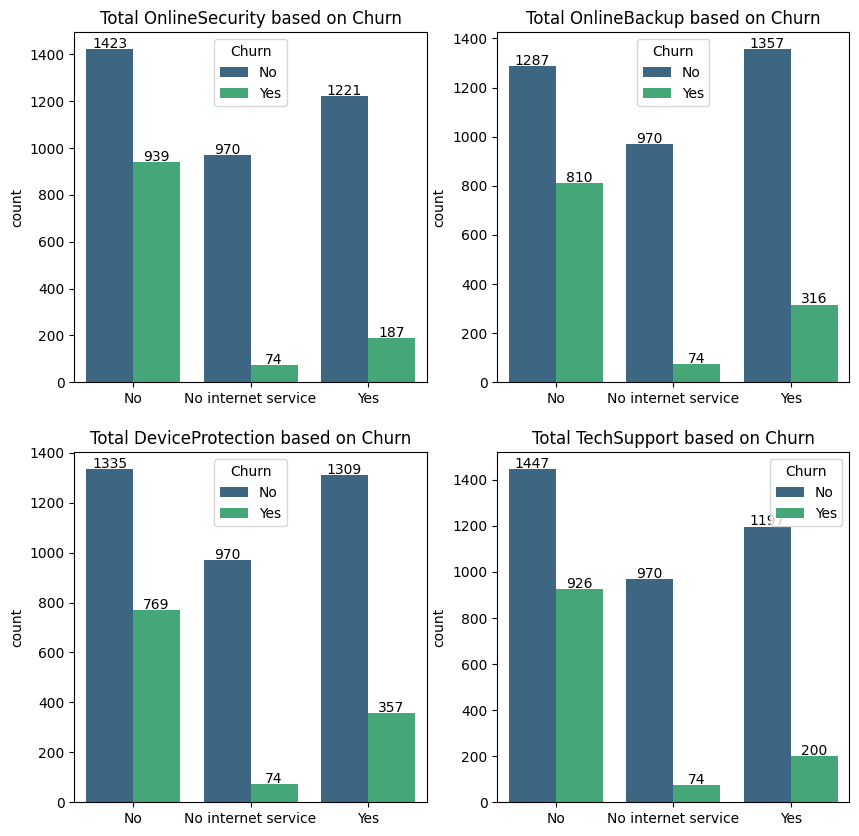

In [80]:
plt.figure(figsize=(10,10))

for i, col in enumerate(['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']):
    plt.subplot(2,2,i+1)
    sns.countplot(
        x=data[col],
        hue=data['Churn'],
        palette='viridis'
    )

    plt.title(f'Total {col} based on Churn'), 
    plt.xlabel('')
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(
            text=f'{p.get_height():.0f}',
            xy=(
                (p.get_x()+(p.get_width()/2)),
                (p.get_height()+5)
            ),
            ha='center'
        )

Based on a brief observation on the historogram above, it is known that the proportion of customers who do not activate the `InternetService` service but still subscribe is much higher than the proportion of customers who churn. The difference ranges up to 13 times more. This applies to all addtional services features because the aggregation of the number of subscribers will automatically be isolated from the `Yes` or `No` class to the `No internet service` class.

On the one hand, customers who use `InternetService` services but do not activate additional services, the proportion of churn customers is far greater than those who still activate additional services. That means churn customers are mostly those who use `InternetService` but do not activate additional services. Even so, there are still other cases where customers who activate additional services will eventually churn. The proportion of customers who churn can be described as follows:

1. In the `OnlineSecurity` feature, it is found that the proportions for the `No` and `Yes` classes are 66 % and 15 % respectively.

1. In the `OnlineBackup` feature, it is found that the proportions for the `No` and `Yes` classes are 63 % and 23 % respectively.
1. In the `DeviceProtection` feature, it is found that the proportions for the `No` and `Yes` classes are 58 % and 27 % respectively.
1. In the `TechSupport` feature, it is found that the proportions for the `No` and `Yes` classes are 64 % and 17 % respectively.

Based on the findings above, there are several reasons why customers who do not use additional services have a very high churn tendency. Among them are the ignorance of customers regarding the availability of additional services, the presence of additional costs that do not want to be charged, the need for additional services, and the presence of obstacles in activating additional services. Solutions that can be offered include the following:

1. Offer a more complete and attractive service package at competitive prices along with discounts and special promotions so that customers will experience added value to the quality of services provided. With better service quality, customer retention will increase so that there will be many considerations if switching services to competitors.

1. Provide education and more detailed information regarding the benefits and advantages of using additional services.
1. Improving the quality and reliability of additional services so that customers will feel satisfied and trust to use them.
1. Evaluate the price of each additional service feature with reference to customer needs and preferences.

The findings above can be used as material for evaluation by the company in preparing future actionable plans. Regarding the proportion of customers who don't churn, the number still dominates across classes for every observed feature. This is in line with the statement regarding Market Research in the third paragraph, namely the number of customers that churn is indeed only a small portion. Therefore, the analysis carried out will be focused on exploring insight related to churn customers.

As previously stated, features such as `tenure` and `MonthlyCharges` do not satisfy the assumptions of normality or homogeneity of variance. Therefore, a Kruskal-Wallis analysis will be conducted to determine whether there is a significant difference between the compared classes of ancillary service features, among which are `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, and `TechSupport`, if associated based on observed non-parametric variables. This can be done using a module from library **Scipy**. First of all, a special calculation will be made for customers who churn.

In [81]:
import scipy.stats as stats

for i in data[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']].columns.values:
    for j in ['tenure','MonthlyCharges']:
        result = stats.kruskal(
            data[(data[i]==data[i].unique()[0]) & (data['Churn']=='Yes')][j],
            data[(data[i]==data[i].unique()[1]) & (data['Churn']=='Yes')][j],
            data[(data[i]==data[i].unique()[2]) & (data['Churn']=='Yes')][j]
        )

        clause = [
            ['below','above'],
            ['significant','insignificant'],
            [' at least two categories ',' ']
        ]

        k = 0 if result.pvalue < 0.05 else 1
        print(
            f'The p-value is {clause[0][k]} 0.05, indicating {clause[1][k]}', 
            f'difference between{clause[2][k]}of the {i} column',
            f'\nfor {j} measurement variable specifically for churned customers.\n'
        )

The p-value is below 0.05, indicating significant difference between at least two categories of the OnlineSecurity column 
for tenure measurement variable specifically for churned customers.

The p-value is below 0.05, indicating significant difference between at least two categories of the OnlineSecurity column 
for MonthlyCharges measurement variable specifically for churned customers.

The p-value is below 0.05, indicating significant difference between at least two categories of the OnlineBackup column 
for tenure measurement variable specifically for churned customers.

The p-value is below 0.05, indicating significant difference between at least two categories of the OnlineBackup column 
for MonthlyCharges measurement variable specifically for churned customers.

The p-value is below 0.05, indicating significant difference between at least two categories of the DeviceProtection column 
for tenure measurement variable specifically for churned customers.

The p-value is below 0.05,

Based on statistical calculations specifically for churn customers, it can be concluded that there are significant differences in the distribution of non-parametric variables between classes compared for each feature of additional services. This indicates that at least one of these classes has a rating or average that is significantly different from the other classes.

Furthermore, the results of the analysis will be visualized to draw general conclusions to determine causality specifically.

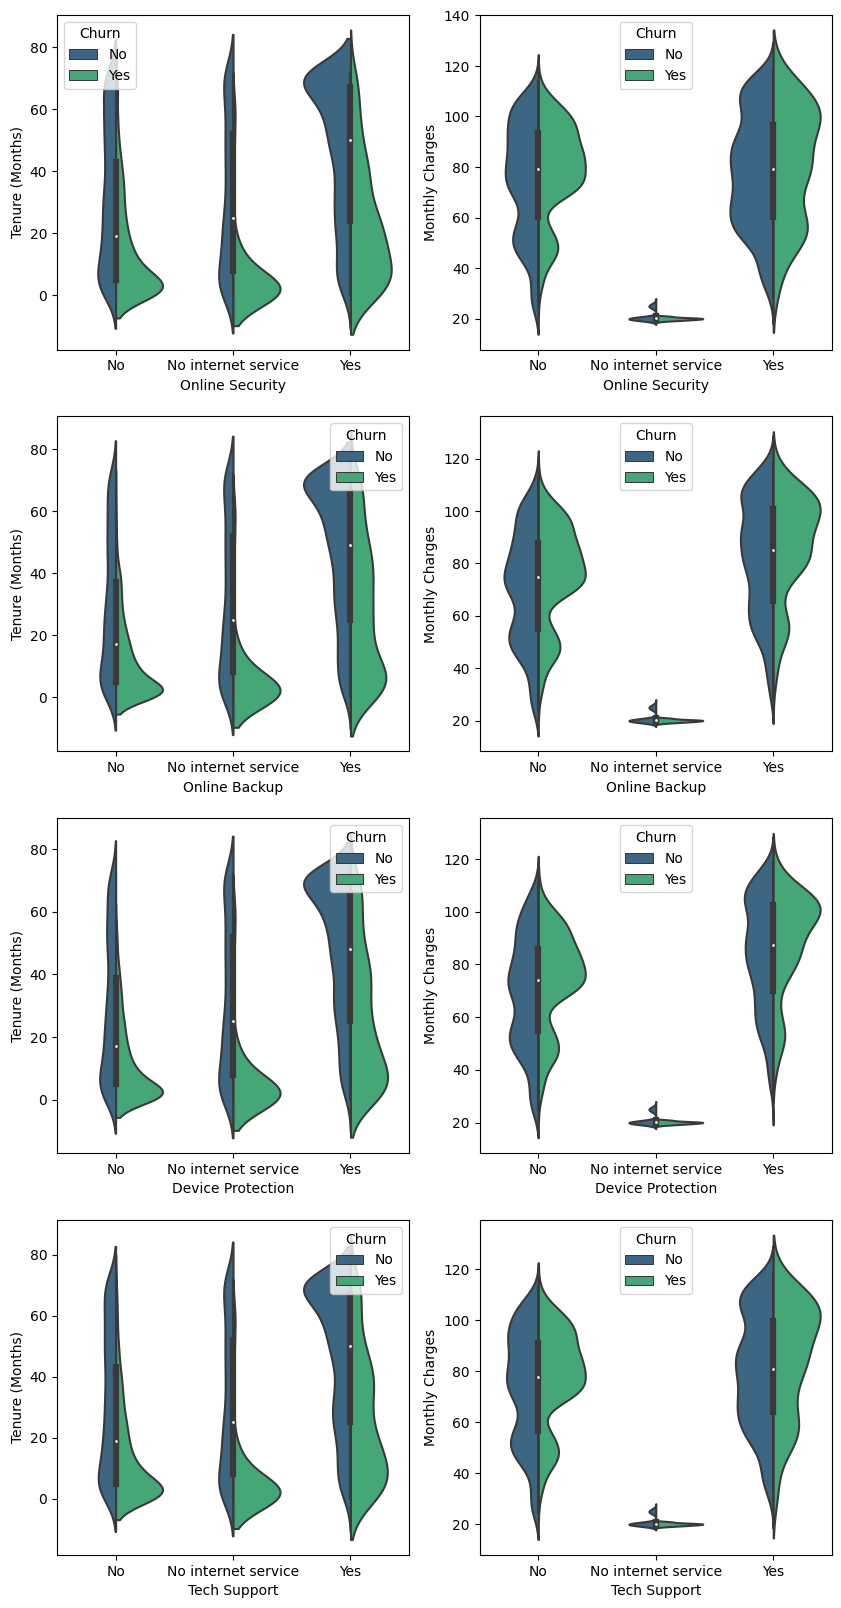

In [82]:
fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(10,20))

for i, col in enumerate(['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']):
    for j in ['tenure','MonthlyCharges']:
        violin = sns.violinplot(
            x=data[col],
            y=data[j],
            hue=data['Churn'],
            split=True,
            ax=ax[i,0 if j == 'tenure' else 1],
            palette='viridis'
        )

        violin.set_ylabel('Tenure (Months)' if j == 'tenure' else 'Monthly Charges')
        violin.set_xlabel(
            'Online Security' if i == 0 else
            'Online Backup' if i == 1 else
            'Device Protection' if i == 2 else
            'Tech Support'
        )

Based on the violinplot visualization above, general information is obtained regarding the density or distribution of customers who churn or do not for the characteristics of each class in the four features. The information described will focus on identifying churn customers, namely as follows:
1. Customers who do not activate additional services, whether they use the `InternetService` service or not, have a tendency to churn when their subscription duration is below 20 months. This is in line with the initial assumptions in the Monthly Charges and Tenure Relationship section. Therefore, this assumption has a fairly good level of validity in interpreting churn customer factors.

1. For customers who activate additional services, the duration of the churn customers is spread wider so that it will be more difficult to detect their tendency to churn.
1. For the monthly bill that is charged, those who do not use the `InternetService` service are charged a very cheap bill compared to others. The currency used is not known, so this feature will only use units. The density is centered around the number 20 for those who churn or not.
1. For those who do not activate additional services, most of those who churn are those who pay a monthly bill of between 70 and 100 for each additional related feature or service.
1. For those who activate additional services, have a wider range of monthly billing values ​​compared to those who do not activate. Thus customers who activate additional services will be more difficult to detect because the range of values ​​is wider.

This interpretation can be used as a reference for companies to predict churn customers so that they can help find the right preventive solutions in preparing actionable plans in the future. For exact calculations, statistical descriptions can be made for quartile values ​​of 25 %, 50 %, and 75 % considering that the `tenure` and `MonthlyCharges` features are non-parametric.

In [83]:
for i in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']:
    display(data[data['Churn']=='Yes'].groupby(i)[[
        'tenure',
        'MonthlyCharges'
    ]].describe()[[
        (col,quantile) for col in ['tenure','MonthlyCharges'] for quantile in ['25%','50%','75%']
    ]])

tenure              MonthlyCharges                       
                       25%   50%    75%            25%        50%         75%
OnlineSecurity                                                               
No                     2.0   8.0  22.00      70.025002  80.550003   93.425003
No internet service    1.0   1.0   6.75      19.612500  19.975000   20.250000
Yes                    8.0  19.0  37.50      59.500000  82.449997  100.299999

tenure              MonthlyCharges                       
                       25%   50%    75%            25%        50%         75%
OnlineBackup                                                                 
No                     2.0   7.0  17.00        69.2500  78.600002   89.537502
No internet service    1.0   1.0   6.75        19.6125  19.975000   20.250000
Yes                    7.0  25.0  44.00        78.7125  90.700001  102.087500

tenure              MonthlyCharges                       
                       25%   50%    75%            25%        50%         75%
DeviceProtection                                                             
No                     1.0   6.0  17.00      68.949997  75.900002   86.500000
No internet service    1.0   1.0   6.75      19.612500  19.975000   20.250000
Yes                    8.0  21.0  41.00      79.900002  94.500000  102.949997

tenure              MonthlyCharges                       
                       25%   50%    75%            25%        50%         75%
TechSupport                                                                  
No                    2.00   8.0  21.00      69.862499  80.174999   91.400002
No internet service   1.00   1.0   6.75      19.612500  19.975000   20.250000
Yes                   8.75  22.0  41.00      66.324999  87.950001  103.449999

The above interpretation can be determined based on which quartile value, namely between 25% or 75%, has the smallest difference to the 50% quartile value. Thus, it can be seen which range of values ​​has the range of values ​​with the largest density.

##### **Ancillary Attributes**

In addition, there are other features that can be used as additional information, including `Dependents`, `Contract`, and `PaperlessBilling`. These features have no causality or significance with InternetService features so they can be referred to as ancillary attributes.

**Dependents Feature**

First of all, a visual analysis will be carried out as an initial step to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `Dependents` feature.

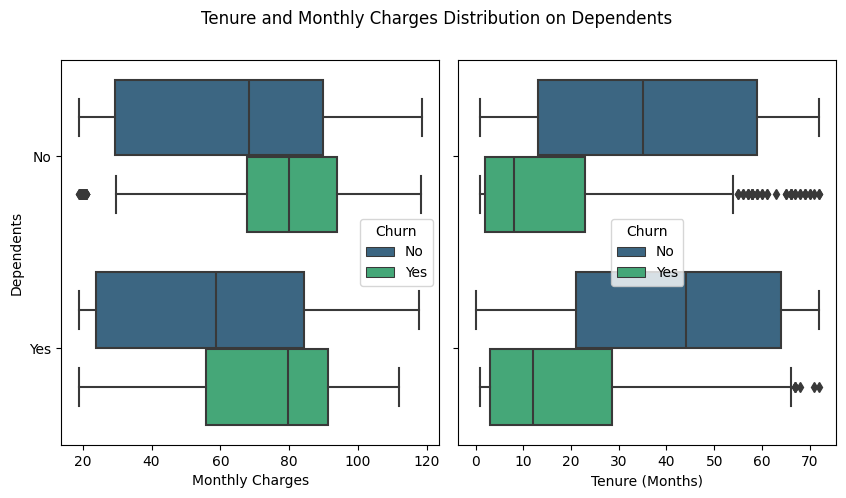

In [84]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Dependents')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['Dependents'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    ax[1].set_ylabel('')

It can be seen that there are outliers for certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. First of all, we examine the relationship between outliers and non-outliers in the `No` class of the `Dependents` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [85]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['Dependents','No'],
    lower_outliers=True
)

diff.get_table()

Outliers                                  Non-Outliers  \
                    count unique                  top freq        count   
OnlineSecurity         60      1  No internet service   60          941   
OnlineBackup           60      1  No internet service   60          941   
InternetService        60      1                   No   60          941   
DeviceProtection       60      1  No internet service   60          941   
TechSupport            60      1  No internet service   60          941   
PaperlessBilling       60      2                   No   42          941   

                                          Outliers  
                 unique          top freq freq (%)  
OnlineSecurity        2           No  794    100.0  
OnlineBackup          2           No  685    100.0  
InternetService       2  Fiber optic  730    100.0  
DeviceProtection      2           No  655    100.0  
TechSupport           2           No  783    100.0  
PaperlessBilling      2          Yes  753     70.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `No internet service` class from the additional services feature and the `No` class from the `InternetService` and `PaperlessBilling` features. The percentage is even up to 100% for the class `No internet services` from the additional services feature and the `No` class from the `InterService` feature which indicates that there are no other classes in the outliers range because in that range is the monthly bill charged to customers who do not use the `InternetService` service.

Therefore, the examination will only be carried out on the `PaperlessBilling` feature considering that this feature does not form a certain pattern on the number of churn subscribers when associated with the `InternetService` feature. Next, a visualization will be carried out to see the distribution.

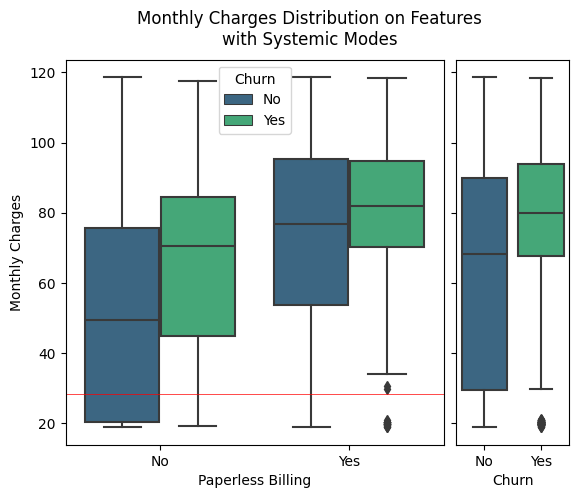

In [86]:
diff.box_plot()

It was found that there are outliers values ​​for the `Yes` class of the `PaperlessBilling` feature that exceed the red lower ourliers line. Therefore, handling will only be carried out for ourliers values ​​that are in the lower ourliers range because they can affect machine learning decisions in making predictions.

In [87]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<diff.lower_value) & 
    (data['Dependents']=='No') &
    (data['PaperlessBilling']=='Yes')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between ourliers and non-outliers in the `No` class of the `Dependents` feature based on the distribution of `tenure` features specifically for churn customers.

In [88]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['Dependents','No'],
    upper_outliers=True
)

diff.get_table()

Outliers                       Non-Outliers         \
                    count unique       top freq        count unique   
OnlineBackup           40      3       Yes   35          943      3   
DeviceProtection       40      3       Yes   38          943      3   
TechSupport            40      3       Yes   20          943      3   
Contract               40      3  One year   16          943      3   

                                      Outliers  
                             top freq freq (%)  
OnlineBackup                  No  681     87.5  
DeviceProtection              No  654     95.0  
TechSupport                   No  764     50.0  
Contract          Month-to-month  904     40.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `Yes` class from the `OnlineBackup`, `DeviceProtection` and `TechSupport` features and the `One year` class from the `Contract` feature. The percentages are respectively 87%, 95%, 50% and 40%. Next, a visualization will be carried out to see the distribution.

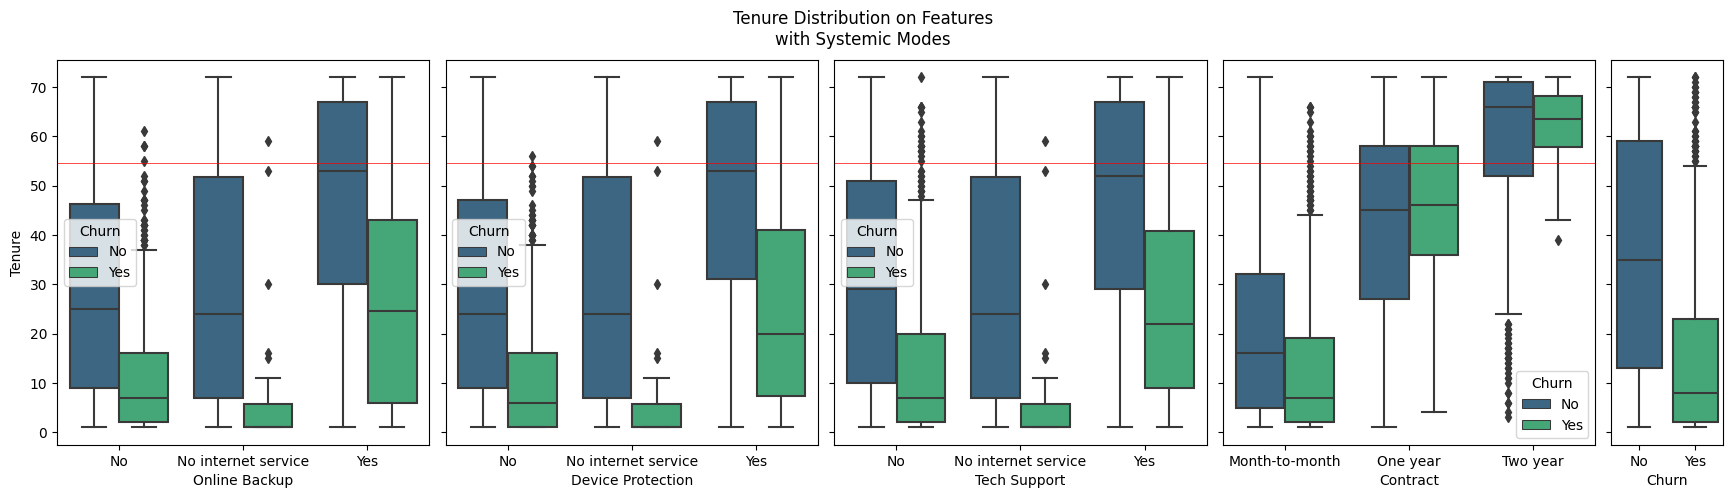

In [89]:
diff.box_plot()

It was found that there were outliers values ​​in several classes that exceeded the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions in that range of values.

In [90]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['Dependents']=='No') &
    (
        (data['OnlineBackup']=='No') | 
        (data['OnlineBackup']=='No internet service') |
        (data['DeviceProtection']=='No') | 
        (data['DeviceProtection']=='No internet service') |
        (data['TechSupport']=='No') | 
        (data['TechSupport']=='No internet service') |
        (data['Contract']=='Month-to-month')
    )
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `Yes` class of the `Dependents` feature based on the distribution of `tenure` features specifically for churn customers.

In [91]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['Dependents','Yes'],
    upper_outliers=True
)

diff.get_table()

Outliers                       Non-Outliers         \
                    count unique       top freq        count unique   
OnlineBackup            6      2       Yes    5          193      3   
DeviceProtection        6      1       Yes    6          193      3   
Contract                6      2  One year    3          193      3   

                                      Outliers  
                             top freq freq (%)  
OnlineBackup                  No  124    83.33  
DeviceProtection              No  114   100.00  
Contract          Month-to-month  163    50.00

It can be seen that there are different modes as an indication of a systemic pattern, namely the `Yes` class from the `OnlineBackup` and `DeviceProtection` features and the `One year` class from the `Contract` feature. The percentages are respectively 83%, 100% and 50%. Next, a visualization will be carried out to see the distribution.

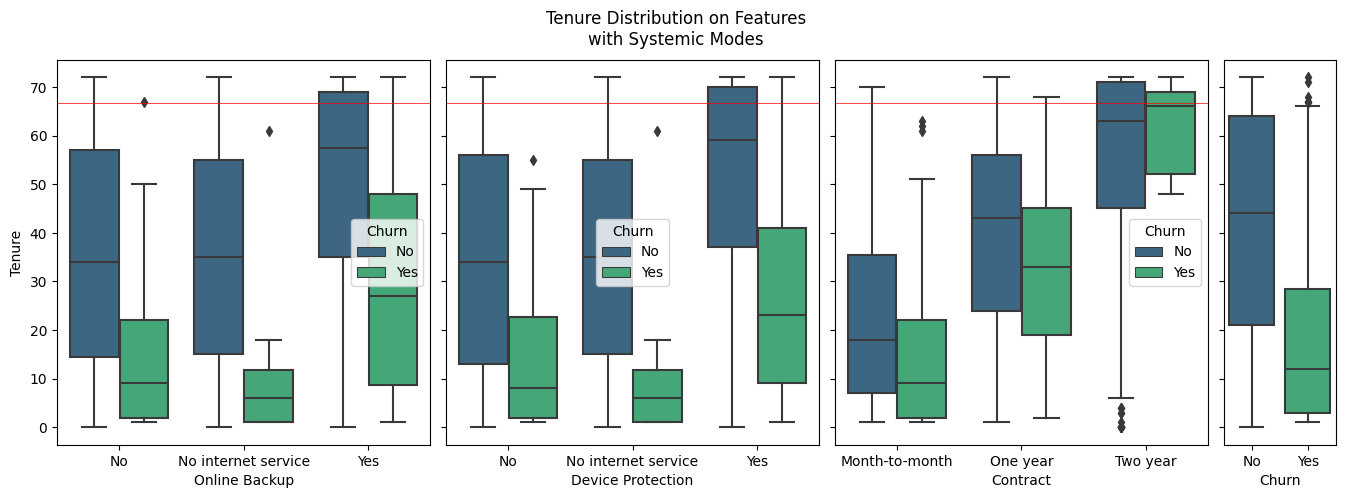

In [92]:
diff.box_plot()

It was found that there are outliers values ​​in the `No` class of the `OnlineBackup` feature that exceed the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range.

In [93]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['Dependents']=='Yes') &
    (data['OnlineBackup']=='No')
].index.values

data = data.drop(index=idx)

Next, a descriptive statistical analysis of the `Dependents` feature will be carried out to find out the distribution of churn customers based on the `tenure` and `MonthlyCharges` features.

In [94]:
data[data['Churn']=='Yes'].groupby('Dependents').describe().transpose()

Dependents                    No         Yes
tenure         count  956.000000  198.000000
               mean    13.791841   18.262626
               std     15.064871   18.201961
               min      1.000000    1.000000
               25%      2.000000    3.000000
               50%      8.000000   12.000000
               75%     21.000000   28.000000
               max     72.000000   72.000000
MonthlyCharges count  956.000000  198.000000
               mean    76.246910   73.480812
               std     21.865177   23.725391
               min     19.250000   19.000000
               25%     69.174997   55.912501
               50%     79.875000   79.500000
               75%     93.587502   91.075001
               max    118.349998  111.949997

Based on this analysis, the insights obtained can be described as follows:

1. Based on those who do not have dependents, most of the subscribers who churn are those whose subscription duration is up to 21 months and the bills charged range from 65 to 95.

1. Based on those who have dependents, most customers who churn are those whose subscription duration is up to 28 months and bills charged range from 55 to 95.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of subscribers who churn were those who subscribed for under 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases, it can be using class based analysis result from `Dependents` feature.

Therefore, companies can identify customers who churn by looking at the central tendency and spread in each class of the `Dependents` feature if it is associated with the `tenure` and `MonthlyCharges` features. Furthermore, a descriptive statistical analysis of the `Dependents` feature will also be carried out to find out the value of the mode that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [95]:
for i in data['Dependents'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['Dependents']==i)
    ][['tenure']].describe()
    
    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn {}'.format(
                'with Dependents' if i == 'Yes' else "without any Dependents"
            ),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['Dependents']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn with Dependents whose Tenure is up to 28 months.


,count,unique,top,freq,freq (%)
Dependents,149,1,Yes,149,100.00
OnlineSecurity,149,3,No,110,73.83
OnlineBackup,149,3,No,105,70.47
InternetService,149,3,Fiber optic,90,60.40
DeviceProtection,149,3,No,97,65.10
TechSupport,149,3,No,111,74.50
Contract,149,2,Month-to-month,135,90.60
PaperlessBilling,149,2,Yes,97,65.10
Churn,149,1,Yes,149,100.00



Descriptive Statistics on Customer Churn with Dependents whose Tenure is more than 28 months.


,count,unique,top,freq,freq (%)
Dependents,49,1,Yes,49,100.00
OnlineSecurity,49,3,No,35,71.43
OnlineBackup,49,3,Yes,29,59.18
InternetService,49,3,Fiber optic,37,75.51
DeviceProtection,49,3,Yes,31,63.27
TechSupport,49,3,No,32,65.31
Contract,49,3,Month-to-month,28,57.14
PaperlessBilling,49,2,Yes,38,77.55
Churn,49,1,Yes,49,100.00



Descriptive Statistics on Customer Churn without any Dependents whose Tenure is up to 21 months.


,count,unique,top,freq,freq (%)
Dependents,718,1,No,718,100.00
OnlineSecurity,718,3,No,598,83.29
OnlineBackup,718,3,No,562,78.27
InternetService,718,3,Fiber optic,509,70.89
DeviceProtection,718,3,No,531,73.96
TechSupport,718,3,No,601,83.70
Contract,718,2,Month-to-month,712,99.16
PaperlessBilling,718,2,Yes,529,73.68
Churn,718,1,Yes,718,100.00



Descriptive Statistics on Customer Churn without any Dependents whose Tenure is more than 21 months.


,count,unique,top,freq,freq (%)
Dependents,238,1,No,238,100.00
OnlineSecurity,238,3,No,176,73.95
OnlineBackup,238,3,No,119,50.00
InternetService,238,3,Fiber optic,198,83.19
DeviceProtection,238,3,No,123,51.68
TechSupport,238,3,No,163,68.49
Contract,238,3,Month-to-month,192,80.67
PaperlessBilling,238,2,Yes,199,83.61
Churn,238,1,Yes,238,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `Dependents` feature which has great potential to cause customers to churn based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [96]:
for i in data['Dependents'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['Dependents']==i)
    ][['MonthlyCharges']].describe()

    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn {}'.format(
                'with Dependents' if i == 'Yes' else "without any Dependents"
            ),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['Dependents']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn with Dependents whose Monthly Charges is between 55.91 and 91.08.


,count,unique,top,freq,freq (%)
Dependents,98,1,Yes,98,100.00
OnlineSecurity,98,2,No,82,83.67
OnlineBackup,98,2,No,68,69.39
InternetService,98,2,Fiber optic,77,78.57
DeviceProtection,98,2,No,67,68.37
TechSupport,98,2,No,77,78.57
Contract,98,3,Month-to-month,87,88.78
PaperlessBilling,98,2,Yes,70,71.43
Churn,98,1,Yes,98,100.00



Descriptive Statistics on Customer Churn with Dependents whose Monthly Charges is less than 55.91 or more than 91.08.


,count,unique,top,freq,freq (%)
Dependents,100,1,Yes,100,100.0
OnlineSecurity,100,3,No,63,63.0
OnlineBackup,100,3,No,56,56.0
InternetService,100,3,Fiber optic,50,50.0
DeviceProtection,100,3,No,47,47.0
TechSupport,100,3,No,66,66.0
Contract,100,3,Month-to-month,76,76.0
PaperlessBilling,100,2,Yes,65,65.0
Churn,100,1,Yes,100,100.0



Descriptive Statistics on Customer Churn without any Dependents whose Monthly Charges is between 69.17 and 93.59.


,count,unique,top,freq,freq (%)
Dependents,478,1,No,478,100.00
OnlineSecurity,478,2,No,435,91.00
OnlineBackup,478,2,No,390,81.59
InternetService,478,2,Fiber optic,460,96.23
DeviceProtection,478,2,No,396,82.85
TechSupport,478,2,No,435,91.00
Contract,478,3,Month-to-month,465,97.28
PaperlessBilling,478,2,Yes,387,80.96
Churn,478,1,Yes,478,100.00



Descriptive Statistics on Customer Churn without any Dependents whose Monthly Charges is less than 69.17 or more than 93.59.


,count,unique,top,freq,freq (%)
Dependents,478,1,No,478,100.00
OnlineSecurity,478,3,No,339,70.92
OnlineBackup,478,3,No,291,60.88
InternetService,478,3,Fiber optic,247,51.67
DeviceProtection,478,3,No,258,53.97
TechSupport,478,3,No,329,68.83
Contract,478,3,Month-to-month,439,91.84
PaperlessBilling,478,2,Yes,341,71.34
Churn,478,1,Yes,478,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `Dependents` feature which has great potential to cause customers to churn based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Contract Features**

Next, a boxplot visualization will be performed to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `Contract` feature.

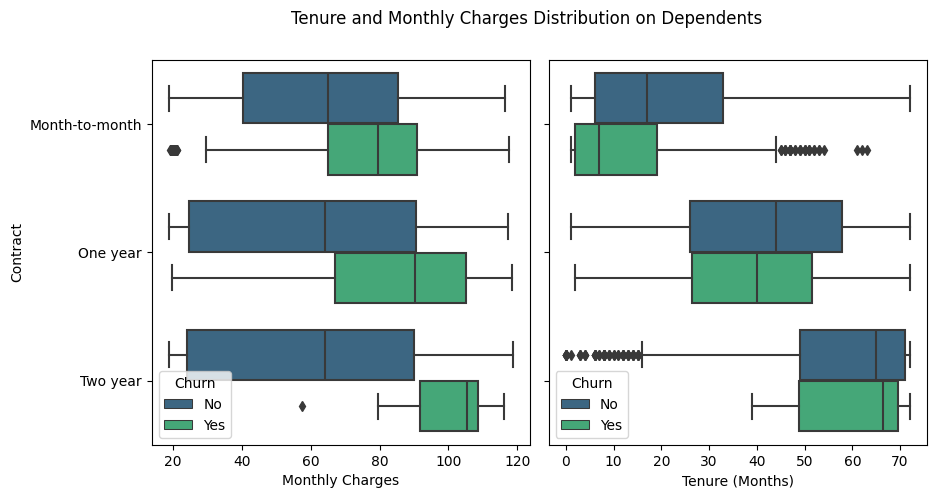

In [97]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Dependents')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['Contract'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    ax[1].set_ylabel('')

It can be seen that there are outliers for certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. First of all, we examine the relationship outliers and non-outliers in the `Month-to-month` class of the `Contract` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [98]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['Contract','Month-to-month'],
    lower_outliers=True
)

diff.get_table()

Outliers                                  Non-Outliers  \
                    count unique                  top freq        count   
OnlineSecurity         51      1  No internet service   51         1016   
OnlineBackup           51      1  No internet service   51         1016   
InternetService        51      1                   No   51         1016   
DeviceProtection       51      1  No internet service   51         1016   
TechSupport            51      1  No internet service   51         1016   
PaperlessBilling       51      2                   No   45         1016   

                                          Outliers  
                 unique          top freq freq (%)  
OnlineSecurity        2           No  869   100.00  
OnlineBackup          2           No  775   100.00  
InternetService       2  Fiber optic  781   100.00  
DeviceProtection      2           No  741   100.00  
TechSupport           2           No  877   100.00  
PaperlessBilling      2          Yes  795    88.24

It can be seen that there are different modes as an indication of a systemic pattern, namely the `No internet service` class from the additional services feature and the `No` class from the `InternetService` and `PaperlessBilling` features. The percentage is even up to 100% for the class `No internet services` from the additional services feature and the `No` class from the `InterService` feature which indicates that there are no other classes in the outliers range because in that range is the monthly bill charged to customers who do not use the `InternetService` service.

Therefore, the examination will only be carried out on the `PaperlessBilling` feature considering that this feature does not form a certain pattern on the number of churn subscribers when associated with the `InternetService` feature. Next, a visualization will be carried out to see the distribution.

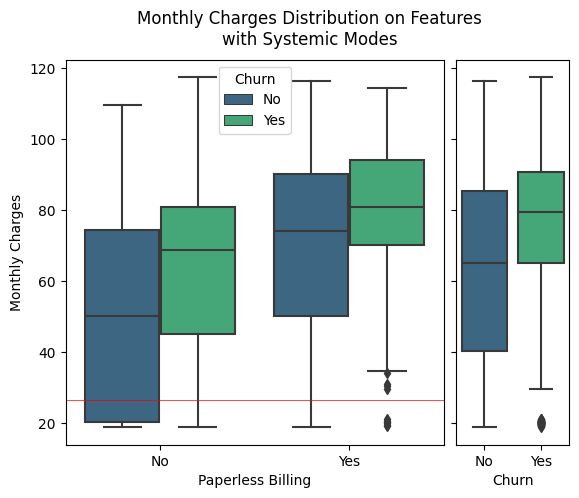

In [99]:
diff.box_plot()

It was found that there are outliers values ​​for the `Yes` class of the `PaperlessBilling` feature that exceed the red lower outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the lower outliers range because they can affect machine learning decisions in that range of values.

In [100]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<diff.lower_value) & 
    (data['Contract']=='Month-to-month') &
    (data['PaperlessBilling']=='Yes')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `Two year` class of the `Contract` feature based on the distribution of the `MonthlyCharges` feature specifically for churn customers.

In [101]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['Contract','Two year'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                    count unique  top freq        count unique          top   
Dependents              1      1  Yes    1           11      2           No   
OnlineSecurity          1      1  Yes    1           11      2           No   
InternetService         1      1  DSL    1           11      2  Fiber optic   
DeviceProtection        1      1   No    1           11      1          Yes   
PaperlessBilling        1      1   No    1           11      2          Yes   

                      Outliers  
                 freq freq (%)  
Dependents          6    100.0  
OnlineSecurity      9    100.0  
InternetService    10    100.0  
DeviceProtection   11    100.0  
PaperlessBilling    9    100.0

It can be seen that there are different modes as an indication of a systemic pattern, namely the `Yes` class from the `Dependents` and `OnlineSecurity` features and the `No` class from the `DeviceProtection` and `PaperlessBilling` features and the `DSL` class from the `InternetService` feature. The percentage even reaches 100% in each class which indicates that there are no other classes in the outliers range. However, if you look at the number of events, there is only one event with these characteristics so outliers can be removed immediately without having to visualize it first.

In [102]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<diff.lower_value) & 
    (data['Contract']=='Two year') &
    (
        (data['PaperlessBilling']=='Yes') | 
        (data['Dependents']=='Yes') | 
        (data['OnlineSecurity']=='Yes') |
        (data['InternetService']=='DSL') | 
        (data['DeviceProtection']=='No')
    )
].index.values

data = data.drop(index=idx)

Next, we will examine the relationship outliers and non-outliers in the `Month-to-month` class of the `Contract` feature based on the distribution of `tenure` features specifically for churn customers.

In [103]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['Contract','Month-to-month'],
    upper_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                  \
                    count unique  top freq        count unique top freq   
OnlineBackup           29      2  Yes   19         1032      3  No  765   
DeviceProtection       29      2  Yes   23         1032      3  No  735   

                 Outliers  
                 freq (%)  
OnlineBackup        65.52  
DeviceProtection    79.31

It can be seen that there is a difference in mode as an indication of a systemic pattern, namely the `Yes` class of the `OnlineBackup` and `DeviceProtection` features whose percentages are 65 % and 79 % respectively. Next, a visualization will be carried out to see the distribution.

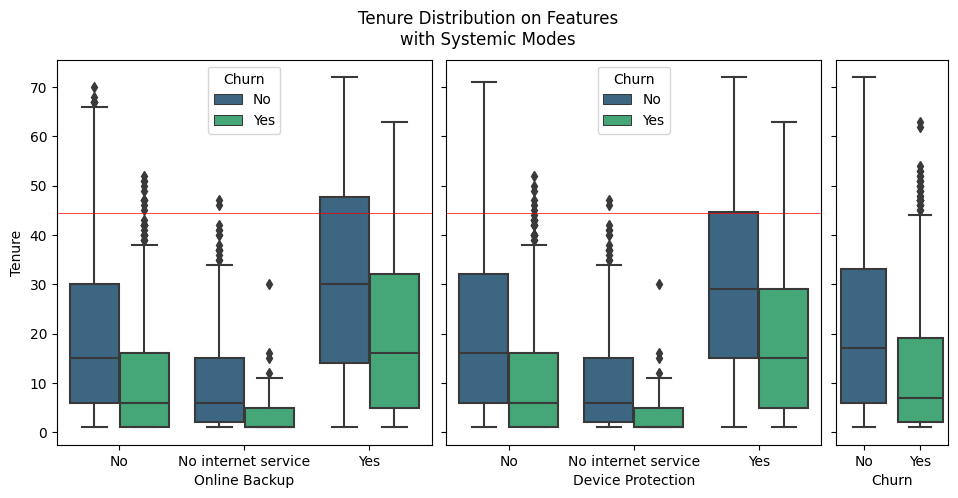

In [104]:
diff.box_plot()

It was found that there were outliers values ​​in several classes that exceeded the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions. Also keep in mind that deletion will only be carried out specifically for churn customers.

In [105]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['Contract']=='Month-to-month') &
    (
        (data['OnlineBackup']=='No') | 
        (data['DeviceProtection']=='No')
    )
].index.values

data = data.drop(index=idx)

Furthermore, there will be no examination of outliers and non-outliers relationships in the `Two year` class of the `Contract` feature based on the distribution of `tenure` features specifically for subscribers who are still subscribed. This is because, when dataset is collected, this information can be considered as new customers who choose a contract duration of 2 years or 24 months and the contract is still ongoing.

Therefore, the customer data becomes outliers because the range of contract durations collected has a maximum value of 72 months or 6 years. This indicates that the number of other customers who first chose the same contract and then extended the duration of the contract will be larger in number so that their central tendency is over 2 years or in other words are non-outliers.

Next, a descriptive statistical analysis of the `Contract` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [106]:
data[data['Churn']=='Yes'].groupby('Contract').describe().transpose()

Contract              Month-to-month    One year    Two year
tenure         count     1045.000000   75.000000   11.000000
               mean        11.734928   39.413333   60.272727
               std         12.286630   18.628004   12.689294
               min          1.000000    2.000000   39.000000
               25%          2.000000   26.500000   48.500000
               50%          7.000000   40.000000   67.000000
               75%         18.000000   51.500000   70.000000
               max         63.000000   72.000000   72.000000
MonthlyCharges count     1045.000000   75.000000   11.000000
               mean        74.971245   84.261345  101.863640
               std         21.364107   26.226110   11.947762
               min         19.000000   19.750000   79.400002
               25%         65.250000   67.000000   99.450001
               50%         79.349998   90.400002  106.000000
               75%         90.599998  105.200001  108.500000
               max        117.449997  118.349998  116.199997

Based on this analysis, the insights obtained can be described as follows:

1. Based on who took the `Month-to-month` contract, most of the subscribers churn were those whose subscription duration was under 18 months and the bills charged ranged from 65 to 95.

1. Based on who took the `One year` contract, most of the customers who churn are those whose subscription duration is between 25 to 52 months and bills charged range from 65 to 110.
1. Based on who took the `Two year` contract, most of the subscribers churn were those whose subscription duration was between 48 to 70 months and the bills charged ranged from 95 to 110.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of customers who churn were those who subscribed for under 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases, it can be using the class-based analysis results from the `Contract` feature.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `Contract` feature when linked to the `tenure` and `MonthlyCharges` features. Furthermore, descriptive statistical analysis of the `Contract` feature will also be carried out to find out the mode value that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [107]:
for i in data['Contract'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['Contract']==i)
    ][['tenure']].describe()

    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['tenure']>=q1) & (data['tenure']<=q3)
    
    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who takes {}'.format(
                f'{i}' if i == 'Month-to-month' else 
                f'{i}' if i == 'Two year' else
                f'{i}'
            ),
            'Contract',
            '{}.'.format('whose Tenure is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                int(q1),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                int(q3)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['Contract']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who takes Month-to-month Contract whose Tenure is between 2 and 18.


,count,unique,top,freq,freq (%)
Dependents,549,2,No,473,86.16
OnlineSecurity,549,3,No,457,83.24
OnlineBackup,549,3,No,420,76.50
InternetService,549,3,Fiber optic,401,73.04
DeviceProtection,549,3,No,394,71.77
TechSupport,549,3,No,453,82.51
Contract,549,1,Month-to-month,549,100.00
PaperlessBilling,549,2,Yes,408,74.32
Churn,549,1,Yes,549,100.00



Descriptive Statistics on Customer Churn who takes Month-to-month Contract whose Tenure is less than 2 or more than 18.


,count,unique,top,freq,freq (%)
Dependents,496,2,No,418,84.27
OnlineSecurity,496,3,No,399,80.44
OnlineBackup,496,3,No,345,69.56
InternetService,496,3,Fiber optic,365,73.59
DeviceProtection,496,3,No,341,68.75
TechSupport,496,3,No,410,82.66
Contract,496,1,Month-to-month,496,100.00
PaperlessBilling,496,2,Yes,373,75.20
Churn,496,1,Yes,496,100.00



Descriptive Statistics on Customer Churn who takes Two year Contract whose Tenure is between 48 and 70.


,count,unique,top,freq,freq (%)
Dependents,5,2,No,3,60.0
OnlineSecurity,5,2,No,3,60.0
OnlineBackup,5,1,Yes,5,100.0
InternetService,5,2,Fiber optic,4,80.0
DeviceProtection,5,1,Yes,5,100.0
TechSupport,5,1,Yes,5,100.0
Contract,5,1,Two year,5,100.0
PaperlessBilling,5,2,Yes,3,60.0
Churn,5,1,Yes,5,100.0



Descriptive Statistics on Customer Churn who takes Two year Contract whose Tenure is less than 48 or more than 70.


,count,unique,top,freq,freq (%)
Dependents,6,2,No,3,50.00
OnlineSecurity,6,1,No,6,100.00
OnlineBackup,6,2,Yes,5,83.33
InternetService,6,1,Fiber optic,6,100.00
DeviceProtection,6,1,Yes,6,100.00
TechSupport,6,2,No,3,50.00
Contract,6,1,Two year,6,100.00
PaperlessBilling,6,1,Yes,6,100.00
Churn,6,1,Yes,6,100.00



Descriptive Statistics on Customer Churn who takes One year Contract whose Tenure is between 26 and 51.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,24,64.86
OnlineSecurity,37,2,No,21,56.76
OnlineBackup,37,2,Yes,21,56.76
InternetService,37,2,Fiber optic,23,62.16
DeviceProtection,37,2,Yes,22,59.46
TechSupport,37,2,Yes,20,54.05
Contract,37,1,One year,37,100.00
PaperlessBilling,37,2,Yes,30,81.08
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who takes One year Contract whose Tenure is less than 26 or more than 51.


,count,unique,top,freq,freq (%)
Dependents,38,2,No,22,57.89
OnlineSecurity,38,3,No,20,52.63
OnlineBackup,38,3,Yes,21,55.26
InternetService,38,3,Fiber optic,20,52.63
DeviceProtection,38,3,Yes,23,60.53
TechSupport,38,3,Yes,24,63.16
Contract,38,1,One year,38,100.00
PaperlessBilling,38,2,Yes,23,60.53
Churn,38,1,Yes,38,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which class has the greatest chance of appearing in each class of the `Contract` feature which has the great potential to cause customers to churn based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [108]:
for i in data['Contract'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['Contract']==i)
    ][['MonthlyCharges']].describe()
    
    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn who takes {}'.format(
                f'{i}' if i == 'Month-to-month' else 
                f'{i}' if i == 'Two year' else 
                f'{i}'
            ),
            'Contract',
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['Contract']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn who takes Month-to-month Contract whose Monthly Charges is between 65.25 and 90.6.


,count,unique,top,freq,freq (%)
Dependents,523,2,No,446,85.28
OnlineSecurity,523,2,No,478,91.40
OnlineBackup,523,2,No,431,82.41
InternetService,523,2,Fiber optic,505,96.56
DeviceProtection,523,2,No,439,83.94
TechSupport,523,2,No,478,91.40
Contract,523,1,Month-to-month,523,100.00
PaperlessBilling,523,2,Yes,415,79.35
Churn,523,1,Yes,523,100.00



Descriptive Statistics on Customer Churn who takes Month-to-month Contract whose Monthly Charges is less than 65.25 or more than 90.6.


,count,unique,top,freq,freq (%)
Dependents,522,2,No,445,85.25
OnlineSecurity,522,3,No,378,72.41
OnlineBackup,522,3,No,334,63.98
InternetService,522,3,Fiber optic,261,50.00
DeviceProtection,522,3,No,296,56.70
TechSupport,522,3,No,385,73.75
Contract,522,1,Month-to-month,522,100.00
PaperlessBilling,522,2,Yes,366,70.11
Churn,522,1,Yes,522,100.00



Descriptive Statistics on Customer Churn who takes Two year Contract whose Monthly Charges is between 99.45 and 108.5.


,count,unique,top,freq,freq (%)
Dependents,5,2,Yes,3,60.0
OnlineSecurity,5,1,No,5,100.0
OnlineBackup,5,1,Yes,5,100.0
InternetService,5,1,Fiber optic,5,100.0
DeviceProtection,5,1,Yes,5,100.0
TechSupport,5,2,No,3,60.0
Contract,5,1,Two year,5,100.0
PaperlessBilling,5,1,Yes,5,100.0
Churn,5,1,Yes,5,100.0



Descriptive Statistics on Customer Churn who takes Two year Contract whose Monthly Charges is less than 99.45 or more than 108.5.


,count,unique,top,freq,freq (%)
Dependents,6,2,No,4,66.67
OnlineSecurity,6,2,No,4,66.67
OnlineBackup,6,2,Yes,5,83.33
InternetService,6,2,Fiber optic,5,83.33
DeviceProtection,6,1,Yes,6,100.00
TechSupport,6,1,Yes,6,100.00
Contract,6,1,Two year,6,100.00
PaperlessBilling,6,2,Yes,4,66.67
Churn,6,1,Yes,6,100.00



Descriptive Statistics on Customer Churn who takes One year Contract whose Monthly Charges is between 67.0 and 105.2.


,count,unique,top,freq,freq (%)
Dependents,37,2,No,22,59.46
OnlineSecurity,37,2,No,23,62.16
OnlineBackup,37,2,No,21,56.76
InternetService,37,2,Fiber optic,24,64.86
DeviceProtection,37,2,Yes,26,70.27
TechSupport,37,2,Yes,21,56.76
Contract,37,1,One year,37,100.00
PaperlessBilling,37,2,Yes,28,75.68
Churn,37,1,Yes,37,100.00



Descriptive Statistics on Customer Churn who takes One year Contract whose Monthly Charges is less than 67.0 or more than 105.2.


,count,unique,top,freq,freq (%)
Dependents,38,2,No,24,63.16
OnlineSecurity,38,3,No,18,47.37
OnlineBackup,38,3,Yes,26,68.42
InternetService,38,3,Fiber optic,19,50.00
DeviceProtection,38,3,Yes,19,50.00
TechSupport,38,3,Yes,23,60.53
Contract,38,1,One year,38,100.00
PaperlessBilling,38,2,Yes,25,65.79
Churn,38,1,Yes,38,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which class has the greatest chance of appearing in each class of the `Contract` feature which has the great potential to cause customers to churn based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Paperless Billing Feature**

Next, a boxplot visualization will be performed to see the distribution of the `tenure` and `MonthlyCharges` features based on the class of the `PaperlessBilling` feature.

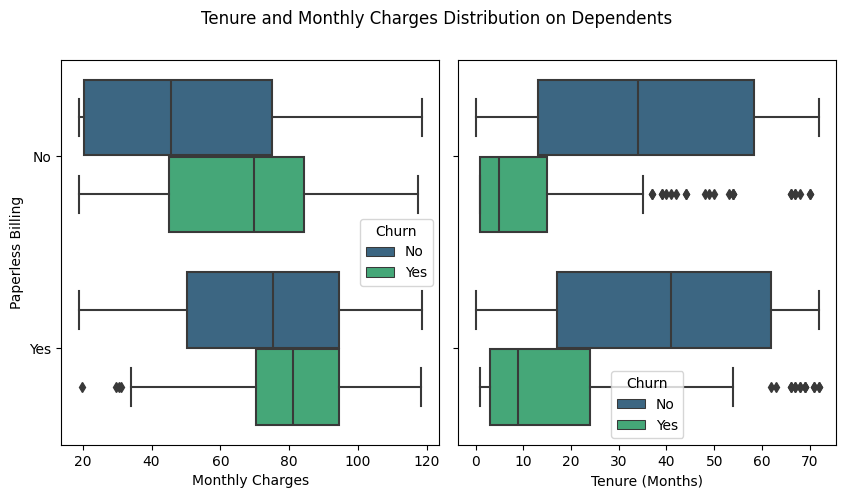

In [109]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(10,5),
    sharey=True,
    gridspec_kw={'wspace':.05}
)

fig.suptitle('Tenure and Monthly Charges Distribution on Dependents')

for i, col in enumerate(['MonthlyCharges','tenure']):
    box = sns.boxplot(
        x=data[col],
        y=data['PaperlessBilling'],
        hue=data['Churn'],
        ax=ax[i],
        palette='viridis'
    )
    
    box.set_xlabel('Monthly Charges' if col == 'MonthlyCharges' else 'Tenure (Months)')
    box.set_ylabel('Paperless Billing' if i == 0 else '')

It can be seen that there are outliers for certain classes. Next, the same method will be carried out as before to check whether there is a difference in mode or not. First of all, we examine the relationship between outliers and non-outliers in the `Yes` class of the `PaperlessBilling` feature based on the distribution of the special `MonthlyCharges` feature for churn customers.

In [110]:
diff = collective_outliers(
    churn='Yes',
    num_var='MonthlyCharges',
    on=['PaperlessBilling','Yes'],
    lower_outliers=True
)

diff.get_table()

Outliers                  Non-Outliers                      \
                   count unique  top freq        count unique          top   
InternetService        4      2  DSL    3          839      2  Fiber optic   
TechSupport            4      3  Yes    2          839      2           No   

                     Outliers  
                freq freq (%)  
InternetService  676     75.0  
TechSupport      707     50.0

It can be seen that there is a difference in mode as an indication of a systemic pattern, namely the `DSL` class from the `InternetService` feature and the `Yes` class from the `TechSupport` feature which are 75 % and 50 % respectively. Next, a visualization will be carried out to see the distribution.

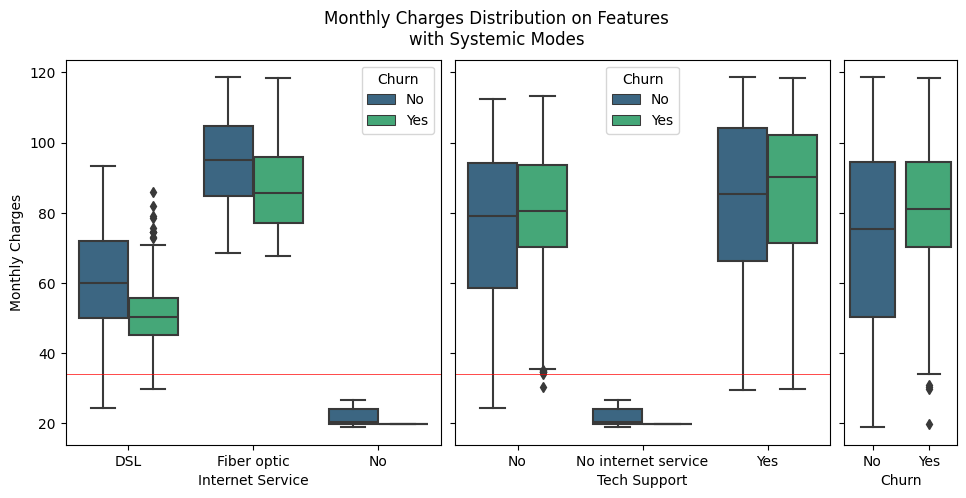

In [111]:
diff.box_plot()

It was found that there is an outliers value in the `No` class of the `TechSupport` feature that exceeds the red lower outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the lower outliers range because they can affect machine learning decisions in that range of values.

In [112]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['MonthlyCharges']<diff.lower_value) & 
    (data['PaperlessBilling']=='Yes') &
    (data['TechSupport']=='No')
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `No` class of the `PaperlessBilling` feature based on the distribution of `tenure` features specifically for churn customers.

In [113]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['PaperlessBilling','No'],
    upper_outliers=True
)

diff.get_table()

Outliers                       Non-Outliers         \
                    count unique       top freq        count unique   
OnlineBackup           23      3       Yes   18          265      3   
DeviceProtection       23      3       Yes   15          265      3   
TechSupport            23      3       Yes   17          265      3   
Contract               23      3  One year   13          265      2   

                                      Outliers  
                             top freq freq (%)  
OnlineBackup                  No  179    78.26  
DeviceProtection              No  166    65.22  
TechSupport                   No  180    73.91  
Contract          Month-to-month  256    56.52

It can be seen that there are different modes as an indication of a systemic pattern, namely the `Yes` class from the `OnlineBackup`, `DeviceProtection` and `TechSupport` features and the `One year` class from the `Contract` feature. The percentages are respectively 78%, 65%, 74% and 56%. Next, a visualization will be carried out to see the distribution.

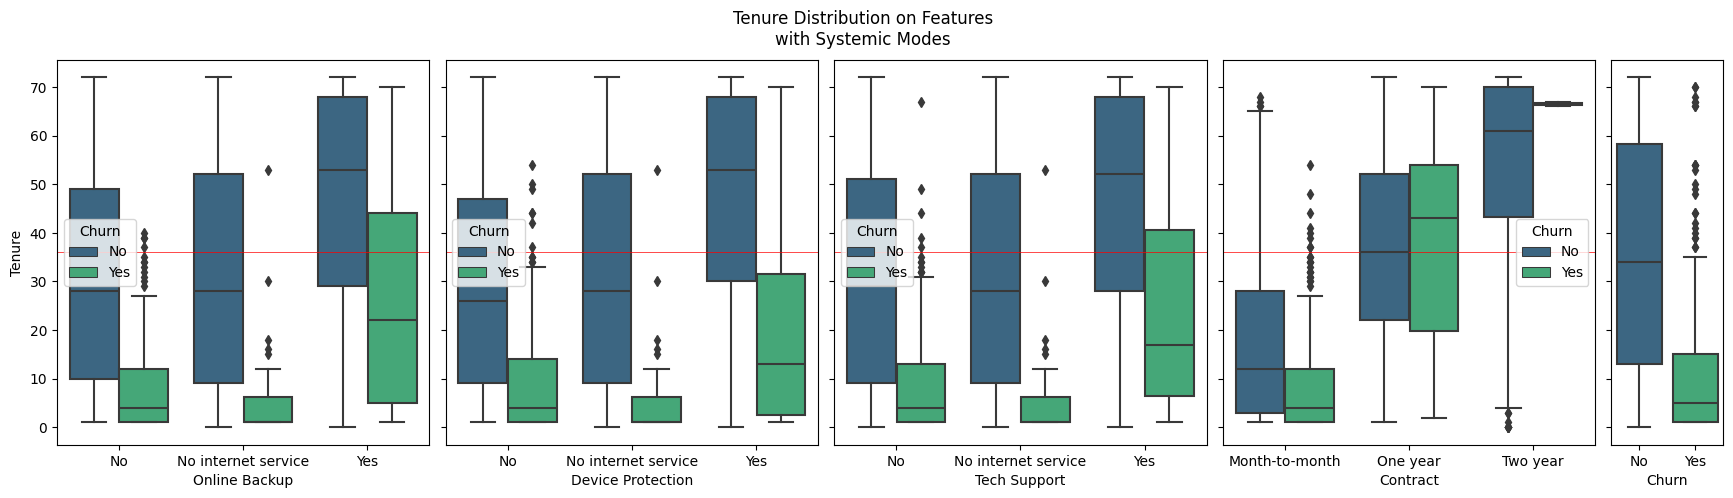

In [114]:
diff.box_plot()

It was found that there were outliers values ​​in several classes that exceeded the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions in that range of values. Also keep in mind that deletion will only be carried out specifically for churn customers.

In [115]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['PaperlessBilling']=='No') &
    (
        (data['OnlineBackup']=='No') | 
        (data['OnlineBackup']=='No internet service') |
        (data['DeviceProtection']=='No') | 
        (data['DeviceProtection']=='No internet service') |
        (data['TechSupport']=='No') | 
        (data['TechSupport']=='No internet service') |
        (data['Contract']=='Month-to-month')
    )
].index.values

data = data.drop(index=idx)

Next, we examine the relationship between outliers and non-outliers in the `Yes` class of the `PaperlessBilling` feature based on the distribution of the `tenure` feature specifically for churn customers.

In [116]:
diff = collective_outliers(
    churn='Yes',
    num_var='tenure',
    on=['PaperlessBilling','Yes'],
    upper_outliers=True
)

diff.get_table()

Outliers                       Non-Outliers         \
                    count unique       top freq        count unique   
OnlineBackup           15      1       Yes   15          827      3   
DeviceProtection       15      1       Yes   15          827      3   
TechSupport            15      2       Yes    9          827      3   
Contract               15      3  One year    8          827      3   

                                      Outliers  
                             top freq freq (%)  
OnlineBackup                  No  611   100.00  
DeviceProtection              No  587   100.00  
TechSupport                   No  701    60.00  
Contract          Month-to-month  778    53.33

It can be seen that there are different modes as an indication of a systemic pattern, namely the `Yes` class from the `OnlineBackup`, `DeviceProtection` and `TechSupport` features and the `One year` class from the `Contract` feature. The percentages are 100 % respectively for the `OnlineBackup` and `DeviceProtection` features, and 60 % and 53 % for the other features. Next, a visualization will be carried out to see the distribution.

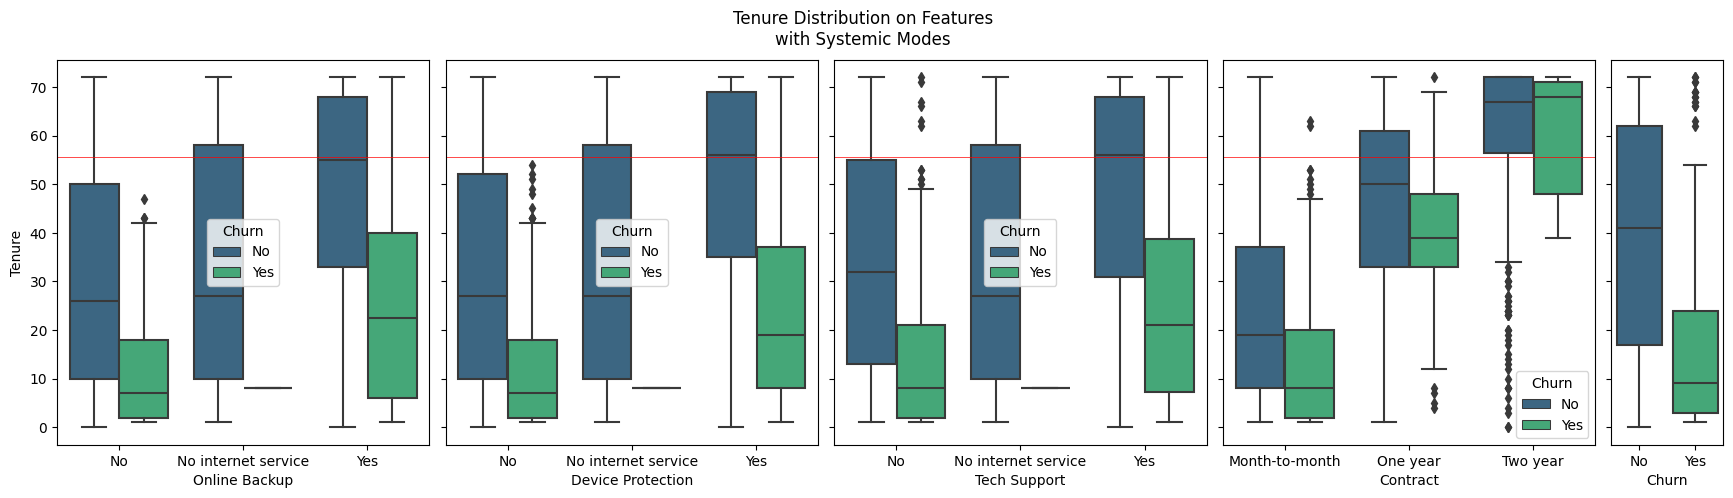

In [117]:
diff.box_plot()

It was found that there were outliers values ​​in several classes that exceeded the red upper outliers line. Therefore, handling will only be carried out for outliers values ​​that are in the upper outliers range because they can affect machine learning decisions in that range of values.

In [118]:
idx = data[
    (data['Churn']=='Yes') & 
    (data['tenure']>diff.upper_value) & 
    (data['PaperlessBilling']=='Yes') &
    (
        (data['TechSupport']=='No') | 
        (data['Contract']=='Month-to-month') |
        (data['Contract']=='One year')
    )
].index.values

data = data.drop(index=idx)

Next, a descriptive statistical analysis of the `PaperlessBilling` feature will be carried out to find out the distribution of churn customers based on the `Tenure` and `MonthlyCharges` features.

In [119]:
data[data['Churn']=='Yes'].groupby('PaperlessBilling').describe().transpose()

PaperlessBilling              No         Yes
tenure         count  272.000000  830.000000
               mean     9.411765   14.173494
               std     12.778251   13.893834
               min      1.000000    1.000000
               25%      1.000000    2.000000
               50%      4.000000    9.000000
               75%     13.000000   23.000000
               max     70.000000   71.000000
MonthlyCharges count  272.000000  830.000000
               mean    62.299633   79.842773
               std     26.190294   17.958569
               min     19.000000   19.750000
               25%     45.037499   70.300003
               50%     69.250000   81.025002
               75%     82.099998   94.400002
               max    116.199997  114.500000

Based on this analysis, the insights obtained can be described as follows:

1. Based on those using the paper-based billing method, most of the customers who churn are those with a subscription duration of up to 13 months and bills charged range from 45 to 85.

1. Based on those using the paperless billing method, most of the customers who churn are those whose subscription duration is up to 23 months and the bills charged range from 70 to 95.

Insights above can be compared with insights previously obtained from customer analysis results that churn based on the `tenure` and `MonthlyCharges` features. The previous analysis was only able to provide a general picture, such as the majority of subscribers who churn were those who subscribed for under 27 months and bills charged ranged from 50 to 100. On the other hand, for more detailed and unpredictable cases, it can be using class-based analysis results from the `PaperlessBilling` feature.

Therefore, companies can identify customers who are churn by looking at the central tendency and spread in each class of the `PaperlessBilling` feature if it is associated with the `tenure` and `MonthlyCharges` features. Furthermore, a descriptive statistical analysis of the `PaperlessBilling` feature will also be carried out to find out the value of the mode that appears when it is associated with other features based on the distribution of the `tenure` feature.

In [120]:
for i in data['PaperlessBilling'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['PaperlessBilling']==i)
    ][['tenure']].describe()
    
    q3 = desc.loc['75%'].values[0]
    slicing = data['tenure']<=q3

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn with {} Billing'.format('Paperless' if i == 'Yes' else "Paper-based"),
            '{}.'.format('whose Tenure is {} {} months'.format(
                'up to' if j == 0 else 'more than',
                int(q3)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['PaperlessBilling']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn with Paperless Billing whose Tenure is up to 23 months.


,count,unique,top,freq,freq (%)
Dependents,630,2,No,549,87.14
OnlineSecurity,630,3,No,554,87.94
OnlineBackup,630,3,No,510,80.95
InternetService,630,3,Fiber optic,494,78.41
DeviceProtection,630,3,No,485,76.98
TechSupport,630,3,No,553,87.78
Contract,630,2,Month-to-month,619,98.25
PaperlessBilling,630,1,Yes,630,100.00
Churn,630,1,Yes,630,100.00



Descriptive Statistics on Customer Churn with Paperless Billing whose Tenure is more than 23 months.


,count,unique,top,freq,freq (%)
Dependents,200,2,No,161,80.5
OnlineSecurity,200,2,No,158,79.0
OnlineBackup,200,2,No,101,50.5
InternetService,200,2,Fiber optic,172,86.0
DeviceProtection,200,2,No,102,51.0
TechSupport,200,2,No,148,74.0
Contract,200,3,Month-to-month,159,79.5
PaperlessBilling,200,1,Yes,200,100.0
Churn,200,1,Yes,200,100.0



Descriptive Statistics on Customer Churn with Paper-based Billing whose Tenure is up to 13 months.


,count,unique,top,freq,freq (%)
Dependents,206,2,No,167,81.07
OnlineSecurity,206,3,No,139,67.48
OnlineBackup,206,3,No,140,67.96
InternetService,206,3,Fiber optic,90,43.69
DeviceProtection,206,3,No,129,62.62
TechSupport,206,3,No,140,67.96
Contract,206,2,Month-to-month,203,98.54
PaperlessBilling,206,1,No,206,100.00
Churn,206,1,Yes,206,100.00



Descriptive Statistics on Customer Churn with Paper-based Billing whose Tenure is more than 13 months.


,count,unique,top,freq,freq (%)
Dependents,66,2,No,49,74.24
OnlineSecurity,66,3,No,40,60.61
OnlineBackup,66,3,No,39,59.09
InternetService,66,3,Fiber optic,44,66.67
DeviceProtection,66,3,No,37,56.06
TechSupport,66,3,No,40,60.61
Contract,66,3,Month-to-month,53,80.30
PaperlessBilling,66,1,No,66,100.00
Churn,66,1,Yes,66,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `PaperlessBilling` feature which has great potential to cause customers to churn based on the distribution of the `tenure` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

Next, a similar analysis will be carried out based on the distribution of the `MonthlyCharges` feature.

In [121]:
for i in data['PaperlessBilling'].unique():
    desc = data[
        (data['Churn']=='Yes') & 
        (data['PaperlessBilling']==i)
    ][['MonthlyCharges']].describe()

    q1, q3 = desc.loc['25%'].values[0], desc.loc['75%'].values[0]
    slicing = (data['MonthlyCharges']>=q1) & (data['MonthlyCharges']<=q3)

    for j, thres in enumerate([slicing,-slicing]):
        print(
            '\nDescriptive Statistics on Customer Churn with {} Billing'.format('Paperless' if i == 'Yes' else "Paper-based"),
            '{}.'.format('whose Monthly Charges is {}{} {} {}{}'.format(
                'between ' if j == 0 else 'less than ',
                round(q1,2),
                'and' if j == 0 else 'or',
                '' if j == 0 else 'more than ',
                round(q3,2)
                )
            )
        )

        stats = data[
            (data['Churn']=='Yes') & 
            (data['PaperlessBilling']==i) & 
            (thres)
        ].describe(include='category').transpose()

        stats['freq (%)'] = stats[[
            'count',
            'freq'
        ]].apply(
            func=lambda x: round(
                number=(x[1]/x[0])*100,
                ndigits=2
            ),
            axis=1
        )
        
        display(stats)


Descriptive Statistics on Customer Churn with Paperless Billing whose Monthly Charges is between 70.3 and 94.4.


,count,unique,top,freq,freq (%)
Dependents,416,2,No,355,85.34
OnlineSecurity,416,2,No,380,91.35
OnlineBackup,416,2,No,327,78.61
InternetService,416,2,Fiber optic,407,97.84
DeviceProtection,416,2,No,338,81.25
TechSupport,416,2,No,377,90.62
Contract,416,3,Month-to-month,407,97.84
PaperlessBilling,416,1,Yes,416,100.00
Churn,416,1,Yes,416,100.00



Descriptive Statistics on Customer Churn with Paperless Billing whose Monthly Charges is less than 70.3 or more than 94.4.


,count,unique,top,freq,freq (%)
Dependents,414,2,No,355,85.75
OnlineSecurity,414,3,No,332,80.19
OnlineBackup,414,3,No,284,68.60
InternetService,414,3,Fiber optic,259,62.56
DeviceProtection,414,3,No,249,60.14
TechSupport,414,3,No,324,78.26
Contract,414,3,Month-to-month,371,89.61
PaperlessBilling,414,1,Yes,414,100.00
Churn,414,1,Yes,414,100.00



Descriptive Statistics on Customer Churn with Paper-based Billing whose Monthly Charges is between 45.04 and 82.1.


,count,unique,top,freq,freq (%)
Dependents,136,2,No,106,77.94
OnlineSecurity,136,2,No,110,80.88
OnlineBackup,136,2,No,117,86.03
InternetService,136,2,DSL,69,50.74
DeviceProtection,136,2,No,110,80.88
TechSupport,136,2,No,112,82.35
Contract,136,3,Month-to-month,132,97.06
PaperlessBilling,136,1,No,136,100.00
Churn,136,1,Yes,136,100.00



Descriptive Statistics on Customer Churn with Paper-based Billing whose Monthly Charges is less than 45.04 or more than 82.1.


,count,unique,top,freq,freq (%)
Dependents,136,2,No,110,80.88
OnlineSecurity,136,3,No,69,50.74
OnlineBackup,136,3,No,62,45.59
InternetService,136,3,Fiber optic,67,49.26
DeviceProtection,136,3,No,56,41.18
TechSupport,136,3,No,68,50.00
Contract,136,3,Month-to-month,124,91.18
PaperlessBilling,136,1,No,136,100.00
Churn,136,1,Yes,136,100.00


The results of the analysis above can be used as material for evaluation by the company regarding which classes have the greatest chance of appearing in each class of the `PaperlessBilling` feature which has great potential to cause customers to churn based on the distribution of the `MonthlyCharges` feature. The results of the analysis are also divided to capture cases that are common cases and edge cases.

**Summary of Ancillary Attributes**

Next, a visualization will be carried out to see distribution and the number of customers who churn or not based on the distribution of the `tenure` and `MonthlyCharges` features for each ancillary attributes. This process will be assisted by using the function `sum_plot()`.

In [122]:
def sum_plot(var):
    fig, ax = plt.subplots(
         figsize=(15,5),
         ncols=3
    )

    fig.suptitle(f'Tenure and Monthly Charges Distribution on {var}')

    sns.countplot(
         x=data[var],
         hue=data['Churn'],
         ax=ax[2],
         palette='viridis'
    )

    axes = plt.gca()
    for p in axes.patches:
            axes.annotate(
                 text=f'{p.get_height():.0f}',
                 xy=(
                    (p.get_x()+(p.get_width()/2)),
                    (p.get_height()+5)
                 ),
                 ha='center'
            )

    for i, col in enumerate(['tenure','MonthlyCharges']):
        sns.violinplot(
             x=data[var],
             y=data[col],
             hue=data['Churn'],
             ax=ax[i],
             palette='viridis',
             split=True
        )
        
        ax[i].set_ylabel('Tenure (Months)' if i == 0 else 'Monthly Charges')

The first thing to check is the `Dependents` feature.

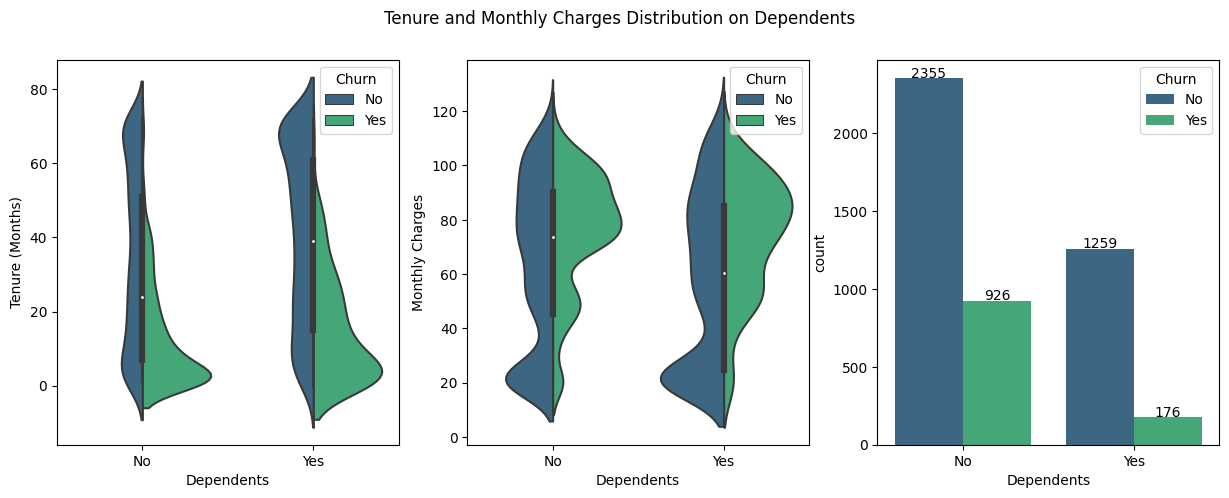

In [123]:
sum_plot('Dependents')

Based on the visualization above, it can be seen that the `Dependents` feature has a large churn portion of customers for the `No` class. The number is large enough that almost half of the total subscribers are still subscribed. On the other hand, the portion of subscribers for the `Yes` class has a ratio of 1 to 7 of subscribers who each subscribe. This raises the assumption that customers who have dependents tend to churn less than customers who do not.

Based on the duration of the subscription, it appears that subscribers who do not have dependents tend to churn faster than those who do not. On the other hand, based on the monthly bills charged, it appears that both customers who churn and those who do not have a different but insignificant distribution of value.

The solution that can be offered is that companies can consider offering discount programs or special promotions for customers with this profile. Psychologically, customers who have no dependents may feel less attached to the `InternetService` used because there are no dependents to consider in their decision. Therefore, they will be more free to switch services to competitors if they feel dissatisfied with the services provided.

Next, the same check will be performed on the `Contract` feature.

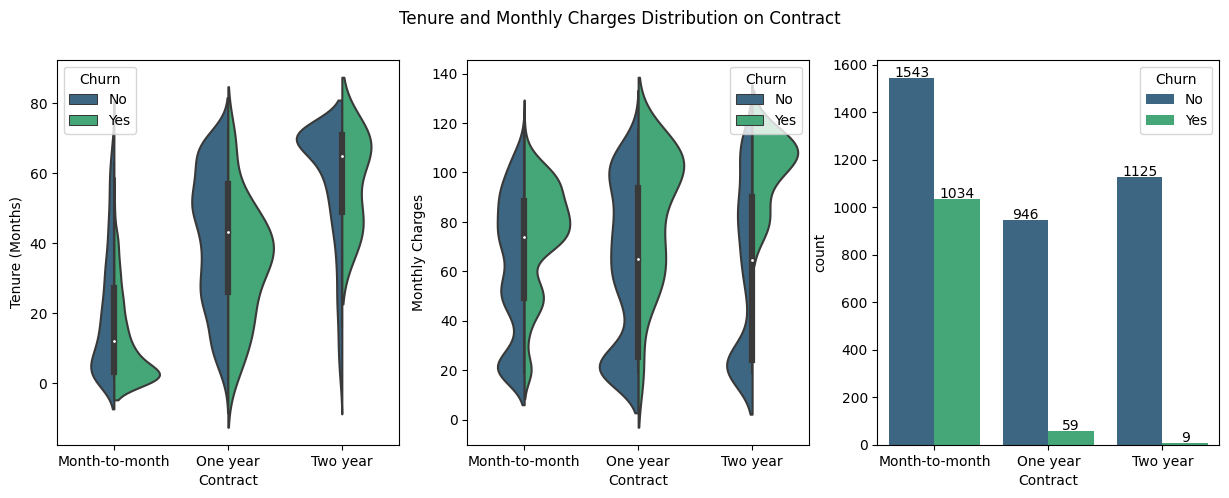

In [124]:
sum_plot('Contract')

Based on the visualization above, it can be seen that the `Contract` feature has a large churn customer portion for the `Month-to-month` class. The amount is large enough to exceed half of the total subscribers who are still subscribed. On the other hand, customers who take the duration of the `One year` contract have a churn portion with a ratio of 1 to 16 from customers who each subscribe. Then, for customers who take the duration of the contract `Two year`, it has a churn portion with a ratio of 1 to 125 from customers who are still subscribed. This leads to the assumption that customers who take `Month-to-month` contract durations result in a much greater propensity to churn than customers who take other contract durations.

Based on the subscription duration, it is seen that customers who take the `Month-to-month` contract duration tend to churn the fastest, followed by `One year` contract duration and then `Two year`. On the other hand, based on the monthly invoices charged, it can be seen that `Two year` contract has the highest central tendency, followed by `One year` and `Month-to-month` contracts.

The solution that can be offered is that the company can provide special services for the duration of `One year` and `Two year` contracts in the form of network maintenance guarantees so that customers can consider using the service in the long term. This needs to be done so that customers feel guaranteed about the quality of the service that will be used so they will not take the duration of the `Month-to-month` contract on a trial and error basis or in other terms referred to as trial customers.

Next, the same check will be carried out on the `PaperlessBilling` feature.

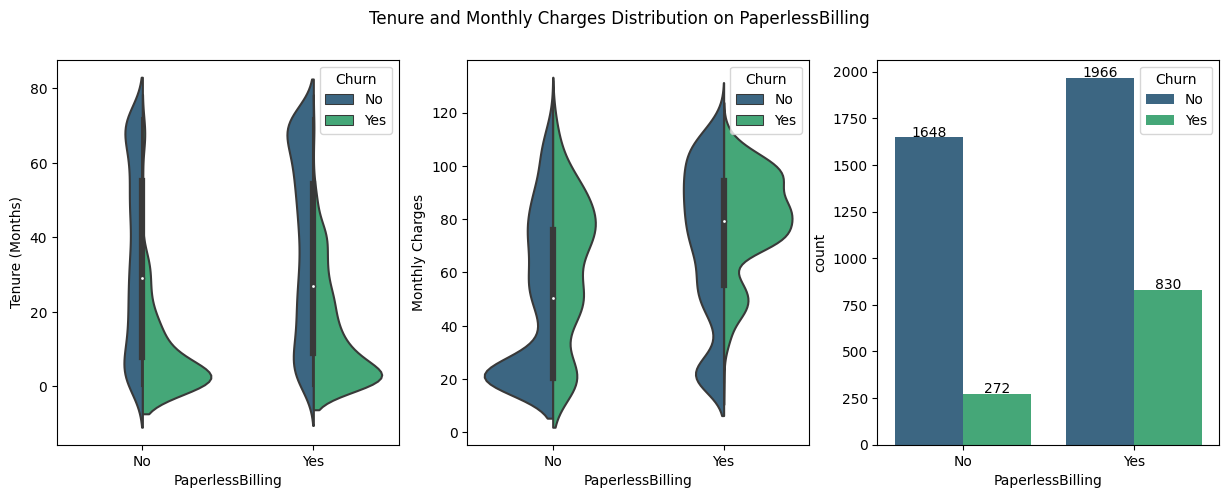

In [125]:
sum_plot('PaperlessBilling')

Based on the visualization above, it can be seen that the `PaperlessBilling` feature has a large portion of churn customers for the `Yes` class. The number is large enough that almost half of the total subscribers are still subscribed. On the other hand, customers who use the paper-based billing method have a churn portion with a ratio of 1 to 6 from subscribers who each subscribe. This raises the assumption that customers who use the paperless billing method have a greater tendency to churn than customers who use the paper-based billing method.

Based on subscription duration, it appears that customers using the paper-based billing method tend to churn faster than those using the paperless billing method. On the other hand, based on the monthly bills charged, it is seen that customers who use the paperless billing method have a relatively and non-significantly different tendency from the paper-based billing method and produce a narrower spread.

Some of the factors that cause bills using the paperless method tend to make customers churn are due to security risks regarding personal financial information and a lack of supervision regarding billing information that is charged. This can be overcome by building a closer relationship with the customer so that they know if there is a change in the rates of the services used so that bad prejudice will not arise, such as the company being considered to have decided unilaterally to increase the price of services for no apparent reason. In addition, from a security point of view, the company must assure customers that personal information, such as financial, will not be misused and the company complies with applicable regulations and laws governing the security of customer personal data.